<a href="https://colab.research.google.com/github/shayanz97/Markt_Agent/blob/main/My_Markt_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Willkommen bei Colab!

## Lernen Sie die Gemini API kennen
Mit der Gemini API erhalten Sie Zugriff auf von Google DeepMind erstellte Gemini-Modelle. Gemini-Modelle sind von Grund auf multimodal, sodass Sie nahtlos mit Text, Bildern, Code und Audioinhalten arbeiten können.

**Erste Schritte**
*  Rufen Sie <a href="https://aistudio.google.com/">Google AI Studio</a> auf und melden Sie sich mit Ihrem Google-Konto an.
*  <a href="https://aistudio.google.com/app/apikey">Erstellen Sie einen API-Schlüssel.</a>
* Verwenden Sie eine Kurzanleitung für <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started.ipynb">Python</a> oder rufen Sie die REST API mit <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/rest/Prompting_REST.ipynb">curl</a> auf.

**Erweiterte Funktionen von Gemini**
*  Experimentieren Sie mit den <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Image-out.ipynb">multimodalen Ausgaben</a> von Gemini, mit denen Sie Text und Bilder auf iterative Weise kombinieren können.
*  Entdecken Sie die <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_LiveAPI.ipynb">multimodale Live API</a>. Eine Demo <a href="https://aistudio.google.com/live">finden Sie hier</a>.
*  Finden Sie heraus, wie Gemini für Sie <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb&quot;">Bilder analysieren und Objekte darin erkennen</a> kann. Es gibt sogar eine <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Spatial_understanding_3d.ipynb">3D‑Version</a>.
*  Nutzen Sie das leistungsfähige <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_thinking.ipynb">Gemini-Thinking-Modell</a>, das mit seinen inneren Gedankengängen komplexe Aufgaben lösen kann.
      
**Komplexe Anwendungsfälle**
*  Verwenden Sie die <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Search_grounding_for_research_report.ipynb">Gemini-Funktionen zur Fundierung</a>, um Berichte zu Unternehmen zu erstellen, die auf den Ergebnissen basieren, die das Modell im Internet findet.
*  Extrahieren Sie auf strukturierte Weise <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Pdf_structured_outputs_on_invoices_and_forms.ipynb">Rechnungs- und Formulardaten aus PDFs</a>.
*  Erstellen Sie mit Imagen und dem großen Kontextfenster von Gemini <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Book_illustration.ipynb">Illustrationen auf Grundlage eines ganzen Buches</a>.

Weitere Informationen finden Sie im <a href="https://github.com/google-gemini/cookbook">Gemini-Cookbook</a> oder in der <a href="https://ai.google.dev/docs/">Gemini API-Dokumentation</a>.


# Markt Agent

In [1]:
# initialise

!pip install ccxt
!pip install ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.1/641.1 kB 14.9 MB/s eta 0:00:00


In [3]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=07957b06a5e3c6dc1ba23b37c50c4c2f7822efa00fb673643a5da2bf4c76cf27
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


## ML Training Code

### v1.0

In [ ]:
import ccxt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
import ta

# === CONFIGURATION ===
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
timeframe = '5m'
limit = 3000  # ca. 10-12 Tage bei 5-min Kerzen

exchange = ccxt.kucoin()  # KuCoin Exchange

all_data = []

for coin in coins:
    try:
        ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')

        # === Features ===
        df['close_change_pct'] = df['close'].pct_change()
        df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
        df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
        df['ma20_diff'] = (df['close'] - df['close'].rolling(20).mean()) / df['close'].rolling(20).mean()
        df['ma50_diff'] = (df['close'] - df['close'].rolling(50).mean()) / df['close'].rolling(50).mean()
        df['momentum'] = df['close'] - df['close'].shift(3)
        df['vol_change'] = df['volume'].pct_change()

        # === Bereinigung: NaN / Inf / Extreme Werte ===
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)

        # Extremwerte clippen
        for col in ['close_change_pct','ma20_diff','ma50_diff','momentum','vol_change']:
            df[col] = df[col].clip(lower=-10, upper=10)

        # === Target definieren ===
        df['target'] = ((df['close'].shift(-3) - df['close']) / df['close']) > 0.002  # 0.2% Anstieg in 3 Kerzen
        df['target'] = df['target'].astype(int)

        df['coin'] = coin
        all_data.append(df)

    except Exception as e:
        print(f"Error loading {coin}: {e}")

# === Combine all coins ===
data = pd.concat(all_data)

features = ['close_change_pct','rsi','atr','ma20_diff','ma50_diff','momentum','vol_change']
X = data[features]
y = data['target']

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === XGBoost Model Training ===
model = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# === Test Accuracy ===
pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))

# === Save Model ===
joblib.dump(model, "ml_model_meme_multi_kucoin.pkl")
print("✅ Multi-Coin ML Model gespeichert als 'ml_model_meme_multi_kucoin.pkl'")


Accuracy: 0.6885245901639344
✅ Multi-Coin ML Model gespeichert als 'ml_model_meme_multi_kucoin.pkl'


### v2.0

In [ ]:
import ccxt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
import ta

# === CONFIGURATION ===
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
timeframe = '5m'
limit = 51840  # mehr Daten für besseres Training

exchange = ccxt.kucoin()  # KuCoin Exchange

all_data = []

for coin in coins:
    try:
        ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')

        # === Features ===
        df['close_change_pct'] = df['close'].pct_change()
        df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
        df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
        df['ma20_diff'] = (df['close'] - df['close'].rolling(20).mean()) / df['close'].rolling(20).mean()
        df['ma50_diff'] = (df['close'] - df['close'].rolling(50).mean()) / df['close'].rolling(50).mean()
        df['momentum'] = df['close'] - df['close'].shift(3)
        df['vol_change'] = df['volume'].pct_change()
        df['vol_ma5'] = df['volume'].rolling(5).mean()
        df['vol_ma10'] = df['volume'].rolling(10).mean()
        df['vol_ratio'] = df['volume'] / (df['vol_ma10']+1e-8)  # Verhältnis aktuelles Volumen / 10er-MA

        # Candle-Muster (Bullish/Bearish Engulfing)
        df['bull_engulf'] = ((df['close'] > df['open'].shift(1)) & (df['open'] < df['close'].shift(1))).astype(int)
        df['bear_engulf'] = ((df['close'] < df['open'].shift(1)) & (df['open'] > df['close'].shift(1))).astype(int)

        # === Bereinigung ===
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        for col in ['close_change_pct','ma20_diff','ma50_diff','momentum','vol_change','vol_ratio']:
            df[col] = df[col].clip(lower=-10, upper=10)

        # === Target: ATR-basiert ===
        df['target'] = ((df['close'].shift(-3) - df['close']) / df['atr']) > 0.5
        df['target'] = df['target'].astype(int)

        df['coin'] = coin
        all_data.append(df)

    except Exception as e:
        print(f"Error loading {coin}: {e}")

# === Combine all coins ===
data = pd.concat(all_data)

features = ['close_change_pct','rsi','atr','ma20_diff','ma50_diff','momentum',
            'vol_change','vol_ma5','vol_ma10','vol_ratio','bull_engulf','bear_engulf']
X = data[features]
y = data['target']

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === XGBoost Training (Hyperparameter-optimiert) ===
model = XGBClassifier(n_estimators=500, max_depth=8, learning_rate=0.03, subsample=0.8, colsample_bytree=0.8, random_state=42)
model.fit(X_train, y_train)

# === Test Accuracy ===
pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))

# === Save Model ===
joblib.dump(model, "ml_model_meme_multi_kucoin_v2.pkl")
print("✅ Verbesserte Multi-Coin ML Model gespeichert als 'ml_model_meme_multi_kucoin_v2.pkl'")


Accuracy: 0.648578811369509
✅ Verbesserte Multi-Coin ML Model gespeichert als 'ml_model_meme_multi_kucoin_v2.pkl'


### v3.0


✅ DOGE/USDT geladen, 1474 Zeilen
✅ SHIB/USDT geladen, 1474 Zeilen
✅ PEPE/USDT geladen, 1474 Zeilen
✅ BONK/USDT geladen, 1471 Zeilen
Fitting 3 folds for each of 32 candidates, totalling 96 fits

✅ Final Accuracy: 0.8991

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 500, 'scale_pos_weight': np.float64(34.71212121212121), 'subsample': 0.8}

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95      1098
           1       0.10      0.06      0.08        81

    accuracy                           0.90      1179
   macro avg       0.52      0.51      0.51      1179
weighted avg       0.88      0.90      0.89      1179



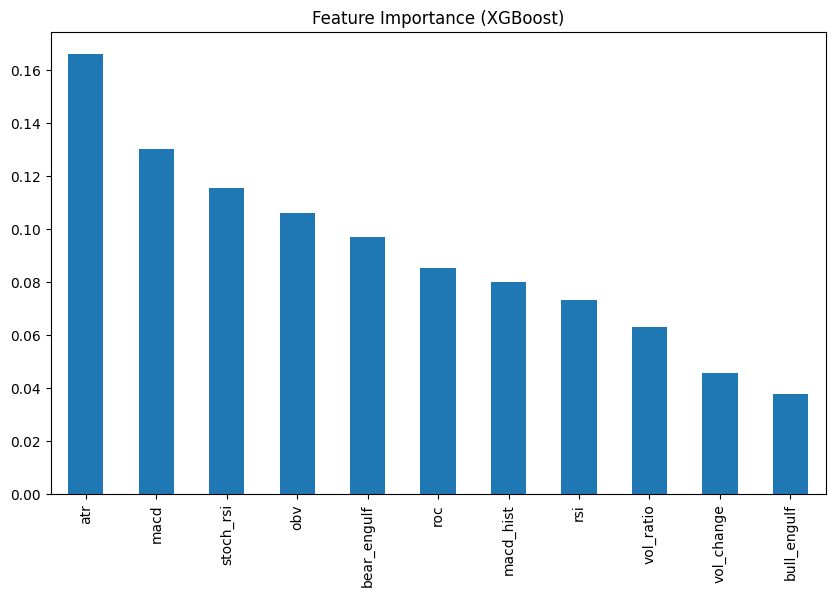

💾 Modell gespeichert als ml_model_meme_kucoin_advanced.pkl


In [ ]:
# === INSTALL ===
!pip install ccxt ta xgboost scikit-learn pandas numpy

# === IMPORTS ===
import ccxt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import joblib
import ta
import warnings
warnings.filterwarnings('ignore')

# === CONFIG ===
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
timeframe = "5m"
limit = 5000  # kann erhöht werden, aber 5000 ist stabil für Colab
exchange = ccxt.kucoin()

all_data = []

# === FETCH & FEATURE ENGINEERING ===
for coin in coins:
    try:
        ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')

        # === Technische Indikatoren ===
        df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
        df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
        df['ema_fast'] = df['close'].ewm(span=12).mean()
        df['ema_slow'] = df['close'].ewm(span=26).mean()
        df['macd'] = df['ema_fast'] - df['ema_slow']
        df['signal'] = df['macd'].ewm(span=9).mean()
        df['macd_hist'] = df['macd'] - df['signal']
        df['stoch_rsi'] = ta.momentum.StochRSIIndicator(df['close']).stochrsi()
        df['roc'] = ta.momentum.ROCIndicator(df['close']).roc()
        df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()

        # === Candle Features ===
        df['bull_engulf'] = ((df['close'] > df['open'].shift(1)) & (df['open'] < df['close'].shift(1))).astype(int)
        df['bear_engulf'] = ((df['close'] < df['open'].shift(1)) & (df['open'] > df['close'].shift(1))).astype(int)

        # === Volumen-Dynamik ===
        df['vol_change'] = df['volume'].pct_change()
        df['vol_ma5'] = df['volume'].rolling(5).mean()
        df['vol_ma10'] = df['volume'].rolling(10).mean()
        df['vol_ratio'] = df['volume'] / (df['vol_ma10']+1e-8)

        # === Zielvariable (Target): Kursanstieg in den nächsten 6 Kerzen > 1% ===
        df['target'] = np.where(df['close'].shift(-6) > df['close'] * 1.01, 1, 0)

        # === Bereinigung ===
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)

        df['coin'] = coin
        all_data.append(df)

        print(f"✅ {coin} geladen, {len(df)} Zeilen")

    except Exception as e:
        print(f"⚠️ Fehler bei {coin}: {e}")

# === Merge all ===
data = pd.concat(all_data)
features = ['rsi','atr','macd','macd_hist','stoch_rsi','roc','obv',
            'vol_change','vol_ratio','bull_engulf','bear_engulf']
X = data[features]
y = data['target']

# === Split (zeitbasiert) ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === Weighting to balance classes ===
scale = y_train.value_counts()[0] / y_train.value_counts()[1]

# === GridSearchCV für XGBoost ===
params = {
    'n_estimators': [300, 500],
    'max_depth': [6, 8],
    'learning_rate': [0.03, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [scale]
}

tscv = TimeSeriesSplit(n_splits=3)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

grid = GridSearchCV(xgb, param_grid=params, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

# === Evaluation ===
pred = best_model.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f"\n✅ Final Accuracy: {acc:.4f}")
print("\nBest Parameters:", grid.best_params_)
print("\nClassification Report:\n", classification_report(y_test, pred))

# === Feature Importance ===
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
imp = pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=False)
imp.plot(kind='bar')
plt.title("Feature Importance (XGBoost)")
plt.show()

# === Save model ===
joblib.dump(best_model, "ml_model_meme_kucoin_advanced.pkl")
print("💾 Modell gespeichert als ml_model_meme_kucoin_advanced.pkl")


### v4.0


In [ ]:
import ccxt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import joblib
import ta

# === CONFIGURATION ===
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
timeframe = '5m'
limit = 51840  # 180 Tage bei 5m Daten

exchange = ccxt.kucoin()

all_data = []

for coin in coins:
    try:
        ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')

        # === Feature Engineering ===
        df['close_change_pct'] = df['close'].pct_change()
        df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
        df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
        df['ma20_diff'] = (df['close'] - df['close'].rolling(20).mean()) / df['close'].rolling(20).mean()
        df['ma50_diff'] = (df['close'] - df['close'].rolling(50).mean()) / df['close'].rolling(50).mean()
        df['momentum'] = df['close'] - df['close'].shift(3)
        df['vol_change'] = df['volume'].pct_change()
        df['vol_ma5'] = df['volume'].rolling(5).mean()
        df['vol_ma10'] = df['volume'].rolling(10).mean()
        df['vol_ratio'] = df['volume'] / (df['vol_ma10'] + 1e-8)

        df['bull_engulf'] = ((df['close'] > df['open'].shift(1)) & (df['open'] < df['close'].shift(1))).astype(int)
        df['bear_engulf'] = ((df['close'] < df['open'].shift(1)) & (df['open'] > df['close'].shift(1))).astype(int)

        # === Data Cleaning ===
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        for col in ['close_change_pct', 'ma20_diff', 'ma50_diff', 'momentum', 'vol_change', 'vol_ratio']:
            df[col] = df[col].clip(lower=-10, upper=10)

        # === Softeres Ziel (0.5% Anstieg innerhalb von 6 Kerzen) ===
        future_close = df['close'].shift(-6)
        df['target'] = (future_close > df['close'] * 1.005).astype(int)

        df['coin'] = coin
        all_data.append(df)

    except Exception as e:
        print(f"Error loading {coin}: {e}")

# === Combine all coins ===
data = pd.concat(all_data)

features = ['close_change_pct', 'rsi', 'atr', 'ma20_diff', 'ma50_diff',
            'momentum', 'vol_change', 'vol_ma5', 'vol_ma10', 'vol_ratio',
            'bull_engulf', 'bear_engulf']
X = data[features]
y = data['target']

# === Rebalancing (gleich viele 0er und 1er) ===
pos = data[data['target'] == 1]
neg = data[data['target'] == 0].sample(len(pos), random_state=42)
balanced = pd.concat([pos, neg]).sample(frac=1, random_state=42)

X_bal = balanced[features]
y_bal = balanced['target']

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, shuffle=False)

# === Optimiertes Modell mit Cross-Validation ===
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [6, 8],
    'learning_rate': [0.03, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=1  # da balanciert
)

grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

# === Evaluate ===
pred = best_model.predict(X_test)
acc = accuracy_score(y_test, pred)

print(f"\n✅ Final Accuracy: {acc:.4f}")
print(f"\nBest Parameters: {grid.best_params_}")
print("\nClassification Report:")
print(classification_report(y_test, pred))

# === Save Model ===
joblib.dump(best_model, "ml_model_meme_multi_kucoin_balanced.pkl")
print("\n✅ Verbesserte & balancierte ML-Datei gespeichert: ml_model_meme_multi_kucoin_balanced.pkl")


Fitting 3 folds for each of 32 candidates, totalling 96 fits

✅ Final Accuracy: 0.6122

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.8}

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.57      0.61       159
           1       0.57      0.67      0.61       135

    accuracy                           0.61       294
   macro avg       0.62      0.62      0.61       294
weighted avg       0.62      0.61      0.61       294


✅ Verbesserte & balancierte ML-Datei gespeichert: ml_model_meme_multi_kucoin_balanced.pkl


### v5.0 (LLM-NN)

In [8]:
import ccxt
import pandas as pd
import numpy as np
import ta
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# === CONFIG ===
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
timeframe = '15m'
limit = 34560  # ca. 1 Woche Daten pro Coin
seq_len = 8
exchange = ccxt.kucoin()

dfs = []

for coin in coins:
    try:
        ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')

        # === Indikatoren ===
        df['rsi'] = ta.momentum.RSIIndicator(df['close'], 14).rsi()
        df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], 14).average_true_range()
        df['ma20'] = df['close'].rolling(20).mean()
        df['ma50'] = df['close'].rolling(50).mean()
        df['ma_diff'] = (df['ma20'] - df['ma50']) / df['ma50']
        df['vol_change'] = df['volume'].pct_change()

        # === Bereinigung ===
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(method='bfill', inplace=True)
        df.fillna(method='ffill', inplace=True)
        df.dropna(inplace=True)

        df['coin'] = coin
        dfs.append(df)

    except Exception as e:
        print(f"Error with {coin}: {e}")

data = pd.concat(dfs)

# === FEATURES ===
features = ['close','volume','rsi','atr','ma_diff','vol_change']

# Fix: Bereinigung VOR dem Scaler!
for col in features:
    data[col] = np.where(np.isfinite(data[col]), data[col], np.nan)
data.fillna(method='bfill', inplace=True)
data.fillna(method='ffill', inplace=True)

# Fix: Clipping extremer Werte
for col in features:
    data[col] = np.clip(data[col], a_min=-1e6, a_max=1e6)

# === Skalierung ===
scaler = StandardScaler()
scaled = scaler.fit_transform(data[features])
scaled_df = pd.DataFrame(scaled, columns=features)

# === Sequenzen ===
X, y = [], []
target_shift = 3
prices = data['close'].values

for i in range(seq_len, len(scaled_df) - target_shift):
    X.append(scaled_df.iloc[i - seq_len:i].values)
    future_return = (prices[i + target_shift] - prices[i]) / prices[i]
    y.append(1 if future_return > 0.005 else 0)

X, y = np.array(X), np.array(y)

# === Split ===
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === LSTM MODEL ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_len, X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=40, batch_size=64, callbacks=[es], verbose=1)

loss, acc = model.evaluate(X_test, y_test)
print(f"✅ LSTM Accuracy: {acc:.4f}")

model.save("ml_model_lstm_meme_kucoin.h5")
model.save("ml_model_lstm_meme_kucoin.keras")
print("✅ Modell gespeichert als 'ml_model_lstm_meme_kucoin.h5'")
print("✅ Modell gespeichert als 'ml_model_lstm_meme_kucoin.keras'")


/tmp/ipython-input-1732349061.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-1732349061.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-1732349061.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-1732349061.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-1732349061.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj

Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7634 - loss: 0.5974 - val_accuracy: 0.7404 - val_loss: 0.5843
Epoch 2/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7923 - loss: 0.5155 - val_accuracy: 0.7404 - val_loss: 0.5740
Epoch 3/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7769 - loss: 0.5345 - val_accuracy: 0.7404 - val_loss: 0.5729
Epoch 4/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7771 - loss: 0.5288 - val_accuracy: 0.7404 - val_loss: 0.5789
Epoch 5/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7759 - loss: 0.5333 - val_accuracy: 0.7404 - val_loss: 0.5755
Epoch 6/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7788 - loss: 0.5274 - val_accuracy: 0.7404 - val_loss: 0.5820
Epoch 7/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7786 - loss: 0.5261 - val_accuracy: 0.7404 - val_loss: 0.5753
Epoch 8/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7934 - loss: 0.5076 - val_accuracy: 0.7404 - val_loss: 0.

✅ LSTM Accuracy: 0.7487
✅ Modell gespeichert als 'ml_model_lstm_meme_kucoin.h5'
✅ Modell gespeichert als 'ml_model_lstm_meme_kucoin.keras'


In [ ]:
model.save("ml_model_lstm_meme_kucoin.keras")

### v6.0


In [4]:
# improved_meme_pipeline.py
import ccxt
import pandas as pd
import numpy as np
import ta
import tensorflow as tf
import random
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, Conv1D, Add, Activation, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import joblib

# -------------------------
# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# === CONFIG ===
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
timeframe = '15m'
limit = 34560
seq_len = 16                # längere Sequenz oft hilfreich
target_horizons = [3, 6, 12]  # unterschiedliche Lookaheads (in 15m bars)
pos_threshold = 0.01        # 1% move (konservativer)
min_volatility = 0.0005     # minimaler ATR/price relative volatility (filter)
use_atr_normalization = True
exchange = ccxt.kucoin()
features_base = ['close','volume']  # will expand

model_type = "tcn"  # "gru" or "tcn"
batch_size = 128
epochs = 60

# -------------------------
def fetch_and_prepare_coin(coin, timeframe, limit):
    ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df.sort_values('time', inplace=True, ignore_index=True)

    # Indicators (base)
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
    df['ma20'] = df['close'].rolling(20).mean()
    df['ma50'] = df['close'].rolling(50).mean()
    df['ma_diff'] = (df['ma20'] - df['ma50']) / df['ma50']
    df['vol_change'] = df['volume'].pct_change()

    # Additional features (D)
    # MACD
    macd = ta.trend.MACD(df['close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_hist'] = macd.macd_diff()
    # Stochastic RSI
    stoch = ta.momentum.StochRSIIndicator(df['close'])
    df['stochrsi_k'] = stoch.stochrsi_k()
    df['stochrsi_d'] = stoch.stochrsi_d()
    # OBV
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()
    # Bollinger %B
    bb = ta.volatility.BollingerBands(df['close'], window=20, window_dev=2)
    df['bb_pct'] = (df['close'] - bb.bollinger_lband()) / (bb.bollinger_hband() - bb.bollinger_lband())
    # VWAP distance approx (per bar): typical price - rolling VWAP-like (approx)
    tp = (df['high'] + df['low'] + df['close']) / 3
    df['vwap_like'] = (tp * df['volume']).rolling(20).sum() / (df['volume'].rolling(20).sum() + 1e-9)
    df['vwap_dist'] = (df['close'] - df['vwap_like']) / (df['vwap_like'] + 1e-9)

    # Cleanup
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.dropna(inplace=True)

    df['coin'] = coin
    return df

# Improved labeling (B): multi-horizon, volatility-aware
def build_labels(df, target_horizons, pos_threshold, min_volatility, use_atr_normalization):
    """
    For each time t, compute max future return over windows in target_horizons.
    Label = 1 if any future max_return > pos_threshold AND ATR/price > min_volatility.
    Also compute an 'intensity' continuous label normalized by ATR (for potential regression).
    """
    prices = df['close'].values
    atr = df['atr'].values
    n = len(df)
    lbl = np.zeros(n, dtype=int)
    intensity = np.zeros(n, dtype=float)

    for t in range(n):
        # compute max future return across horizons
        max_ret = -np.inf
        for h in target_horizons:
            if t + h < n:
                fut = prices[t+1:t+1+h]  # consider subsequent bars within horizon
                if len(fut) == 0:
                    continue
                max_future = np.max(fut)
                ret = (max_future - prices[t]) / (prices[t] + 1e-9)
                if ret > max_ret:
                    max_ret = ret
        if max_ret == -np.inf:
            max_ret = 0.0

        # volatility filter: skip labeling in extremely quiet markets
        vol_rel = atr[t] / (prices[t] + 1e-9)
        if vol_rel < min_volatility:
            lbl[t] = 0
            intensity[t] = 0.0
            continue

        # ATR-normalized intensity (optional)
        if use_atr_normalization and atr[t] > 0:
            intensity[t] = max_ret / (atr[t] / (prices[t] + 1e-9) + 1e-9)
        else:
            intensity[t] = max_ret

        # threshold
        if max_ret > pos_threshold:
            lbl[t] = 1
        else:
            lbl[t] = 0

    return lbl, intensity

# Sequence builder
def build_sequences(df, features, seq_len, target_horizons, pos_threshold, min_volatility, use_atr_normalization):
    lbls, intensity = build_labels(df, target_horizons, pos_threshold, min_volatility, use_atr_normalization)
    X, y = [], []
    for i in range(seq_len, len(df)):
        if i >= len(df):
            break
        window = df.iloc[i-seq_len:i]
        X.append(window[features].values)
        y.append(lbls[i])
    return np.array(X), np.array(y)

# Collect data coin-wise, assemble features list (including coin one-hot)
dfs = []
df_coins = {}
for coin in coins:
    try:
        df_coin = fetch_and_prepare_coin(coin, timeframe, limit)
        df_coins[coin] = df_coin
    except Exception as e:
        print(f"Error fetching {coin}: {e}")

# Build features list dynamically
# Start with base features and add engineered ones we created earlier
features = [
    'close','volume','rsi','atr','ma_diff','vol_change',
    'macd','macd_signal','macd_hist','stochrsi_k','stochrsi_d',
    'obv','bb_pct','vwap_dist'
]

# One-hot coin columns will be appended later

# Build sequences and split per coin
X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

for coin, df_coin in df_coins.items():
    # add coin one-hot columns
    df = df_coin.copy()
    df = pd.get_dummies(df, columns=['coin'])  # adds coin_DOGE/USDT etc.
    # ensure our features exist after get_dummies
    # extend feature list to include coin dummies if not already
    coin_cols = [c for c in df.columns if c.startswith('coin_')]
    fea = features + coin_cols

    # Build sequences
    X_coin, y_coin = build_sequences(df, fea, seq_len, target_horizons, pos_threshold, min_volatility, use_atr_normalization)
    if len(X_coin) < 200:
        print(f"Skipping {coin} because not enough sequences: {len(X_coin)}")
        continue

    # Chronological split per coin
    split_idx = int(0.8 * len(X_coin))
    X_train_list.append(X_coin[:split_idx])
    y_train_list.append(y_coin[:split_idx])
    X_test_list.append(X_coin[split_idx:])
    y_test_list.append(y_coin[split_idx:])

# Combine coins
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

print("Data shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)
n_features = X_train.shape[2]

# Scale features: fit scaler on flattened training windows per feature column
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, n_features)
scaler.fit(X_train_flat)
X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
X_test_flat = X_test.reshape(-1, n_features)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

# Clip extremes
X_train_scaled = np.clip(X_train_scaled, -1e6, 1e6)
X_test_scaled = np.clip(X_test_scaled, -1e6, 1e6)

# Class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)
print("Train class dist:", np.bincount(y_train))
print("Test class dist:", np.bincount(y_test))

# === A: Focal Loss implementation ===
import tensorflow.keras.backend as K

def focal_loss(alpha=0.75, gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # clip to avoid log(0) instabilities
        eps = K.epsilon()
        y_pred = K.clip(y_pred, eps, 1.0 - eps)
        # BCE
        bce = - (y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        modulating_factor = K.pow(1.0 - p_t, gamma)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        loss = alpha_factor * modulating_factor * bce
        return K.mean(loss)
    return loss_fn

# === C: Model builders ===

def build_gru_model(seq_len, n_features):
    inp = Input(shape=(seq_len, n_features))
    x = GRU(128, return_sequences=True)(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = GRU(64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)

def tcn_block(x, filters, kernel_size, dilation_rate, dropout):
    prev = x
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # 1x1 conv to match dimensions if needed
    if prev.shape[-1] != x.shape[-1]:
        prev = Conv1D(filters, kernel_size=1, padding='same')(prev)
    out = Add()([prev, x])
    out = Activation('relu')(out)
    return out

def build_tcn_model(seq_len, n_features, num_blocks=3, filters=64, kernel_size=3, dropout=0.2):
    inp = Input(shape=(seq_len, n_features))
    x = inp
    # Stack dilated causal conv blocks with exponentially increasing dilation
    for i in range(num_blocks):
        dilation_rate = 2 ** i
        x = tcn_block(x, filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, dropout=dropout)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)

if model_type == "gru":
    model = build_gru_model(seq_len, n_features)
else:
    model = build_tcn_model(seq_len, n_features)

model.compile(optimizer='adam', loss=focal_loss(alpha=0.75, gamma=2.0),
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

model.summary()

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
mc = ModelCheckpoint("best_model_advanced.keras", monitor='val_auc', mode='max', save_best_only=True)

# Train
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weight_dict,
    callbacks=[es, rlr, mc],
    verbose=1
)

# Evaluate
probs = model.predict(X_test_scaled).flatten()
preds = (probs >= 0.5).astype(int)

acc = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, probs)
cm = confusion_matrix(y_test, preds)
report = classification_report(y_test, preds, digits=4)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test ROC-AUC : {auc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

# Save artifacts
model.save("ml_model_advanced_meme.keras")
joblib.dump(scaler, "scaler_advanced.pkl")
print("Saved model and scaler.")


/tmp/ipython-input-1691667856.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-1691667856.py:77: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-1691667856.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-1691667856.py:77: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-1691667856.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj

Data shapes: (4748, 16, 15) (4748,) (1188, 16, 15) (1188,)
Class weights: {np.int64(0): np.float64(0.7816924596641422), np.int64(1): np.float64(1.3874926943308008)}
Train class dist: [3037 1711]
Test class dist: [785 403]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16, 15)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 16, 64)    │      2,944 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 64)    │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 16, 64)    │     12,352 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 16, 64)    │      1,024 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 64)    │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 16, 64)    │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 16, 64)    │     12,352 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64)    │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 64)    │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 16, 64)    │     12,352 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64)    │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 16, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16, 64)    │          0 │ activation_2[0][… │
│                     │                   │            │ activation_4[0][

 Total params: 71,489 (279.25 KB)

 Trainable params: 70,721 (276.25 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.4561 - auc: 0.5162 - loss: 0.1447 - val_accuracy: 0.5516 - val_auc: 0.6186 - val_loss: 0.0777 - learning_rate: 0.0010
Epoch 2/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4941 - auc: 0.5894 - loss: 0.0801 - val_accuracy: 0.5495 - val_auc: 0.5561 - val_loss: 0.0781 - learning_rate: 0.0010
Epoch 3/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.4971 - auc: 0.6418 - loss: 0.0718 - val_accuracy: 0.4800 - val_auc: 0.5144 - val_loss: 0.0820 - learning_rate: 0.0010
Epoch 4/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5184 - auc: 0.6727 - loss: 0.0671 - val_accuracy: 0.4863 - val_auc: 0.5500 - val_loss: 0.0831 - learning_rate: 0.0010
Epoch 5/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5456 - auc: 0.7066 - loss: 0.0647 - val_accuracy: 0.4821 - val_auc: 0.5323 - val_loss: 0.0877 - learning_rate: 5.0000e-04
Epoch 6/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5663 - auc: 0.72

## Bot

### v1.0 + ML v2.0

In [ ]:
import ccxt
import pandas as pd
import numpy as np
import ta
import joblib

# === CONFIGURATION ===
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
start_balance = 100
interval = '5m'
limit = 5000  # kürzere Testperiode

ml_model_path = "ml_model_meme_kucoin_advanced.pkl"
ml_threshold = 0.6
rsi_buy = 30
rsi_sell = 70

exchange = ccxt.kucoin()
exchange.load_markets()
model = joblib.load(ml_model_path)

results = []
all_trades = []

available_coins = [c for c in coins if c in exchange.markets]
print("Verfügbare Coins für Backtest:", available_coins)

for coin in available_coins:
    try:
        ohlcv = exchange.fetch_ohlcv(coin, interval, limit=limit)
        if len(ohlcv) == 0:
            print(f"No data for {coin}, skipping...")
            continue

        df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')

        # === Features berechnen ===
        df['close_change_pct'] = df['close'].pct_change()
        df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=7).rsi()  # kürzeres RSI
        df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=7).average_true_range()  # kürzeres ATR
        df['ma20_diff'] = (df['close'] - df['close'].rolling(10).mean()) / df['close'].rolling(10).mean()  # kürzeres MA
        df['ma50_diff'] = (df['close'] - df['close'].rolling(20).mean()) / df['close'].rolling(20).mean()  # kürzeres MA
        df['momentum'] = df['close'] - df['close'].shift(3)
        df['vol_change'] = df['volume'].pct_change()
        df['vol_ma5'] = df['volume'].rolling(3).mean()
        df['vol_ma10'] = df['volume'].rolling(5).mean()
        df['vol_ratio'] = df['volume'] / (df['vol_ma10'] + 1e-8)
        df['bull_engulf'] = ((df['close'] > df['open'].shift(1)) & (df['open'] < df['close'].shift(1))).astype(int)
        df['bear_engulf'] = ((df['close'] < df['open'].shift(1)) & (df['open'] > df['close'].shift(1))).astype(int)

        df.replace([np.inf, -np.inf], np.nan, inplace=True)

        features = ['close_change_pct','rsi','atr','ma20_diff','ma50_diff','momentum',
                    'vol_change','vol_ma5','vol_ma10','vol_ratio','bull_engulf','bear_engulf']

        # NaNs sanft füllen
        df[features] = df[features].fillna(method='bfill').fillna(method='ffill')

        balance = start_balance
        position = None
        entry_price = 0
        trades = []

        for i in range(len(df)):
            price = df.loc[i,'close']
            rsi = df.loc[i,'rsi']
            X_current = df.loc[i, features].values.reshape(1,-1)
            ml_score = model.predict_proba(X_current)[0][1]

            # Kaufbedingung
            if position is None and rsi < rsi_buy and ml_score > ml_threshold:
                position = 'LONG'
                entry_price = price
                trades.append({'coin':coin,'time':df.loc[i,'time'],'action':'BUY','price':price,'rsi':rsi,'ml_score':ml_score})

            # Verkauf
            elif position == 'LONG' and (rsi > rsi_sell or ml_score < (1-ml_threshold)):
                profit_pct = (price - entry_price)/entry_price*100
                balance *= (1 + profit_pct/100)
                position = None
                trades.append({'coin':coin,'time':df.loc[i,'time'],'action':'SELL','price':price,'rsi':rsi,'ml_score':ml_score,'profit_%':profit_pct})

        results.append({'coin':coin,'final_balance':balance,'change_%':(balance-start_balance)/start_balance*100})
        all_trades.extend(trades)

    except Exception as e:
        print(f"Error with {coin}: {e}")

# === Export CSV ===
results_df = pd.DataFrame(results)
trades_df = pd.DataFrame(all_trades)
results_df.to_csv("backtest_summary_ml_meme.csv", index=False)
trades_df.to_csv("backtest_trades_ml_meme.csv", index=False)

print("✅ ML+RSI Backtest für Meme-Coins abgeschlossen!")
print(results_df)


Verfügbare Coins für Backtest: ['DOGE/USDT', 'SHIB/USDT', 'PEPE/USDT', 'BONK/USDT']
Error with DOGE/USDT: Feature shape mismatch, expected: 11, got 12
Error with SHIB/USDT: Feature shape mismatch, expected: 11, got 12
Error with PEPE/USDT: Feature shape mismatch, expected: 11, got 12
Error with BONK/USDT: Feature shape mismatch, expected: 11, got 12
✅ ML+RSI Backtest für Meme-Coins abgeschlossen!
Empty DataFrame
Columns: []
Index: []


### v2.0 + ML v5.0

#### 1 coin

/tmp/ipython-input-3765189119.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-3765189119.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Optimale Schwelle: 0.44999999999999996
Endbalance: 100.24 USDT (Start: 100 USDT)
                 time action     price     balance  profit_%
3 2025-11-14 09:00:00   SELL  0.000005  101.182918 -0.616131
4 2025-11-14 09:45:00    BUY  0.000005  101.182918       NaN
5 2025-11-14 10:30:00   SELL  0.000005  102.264262  1.068702
6 2025-11-14 17:15:00    BUY  0.000005  102.264262       NaN
7 2025-11-14 17:45:00   SELL  0.000005  100.244717 -1.974831


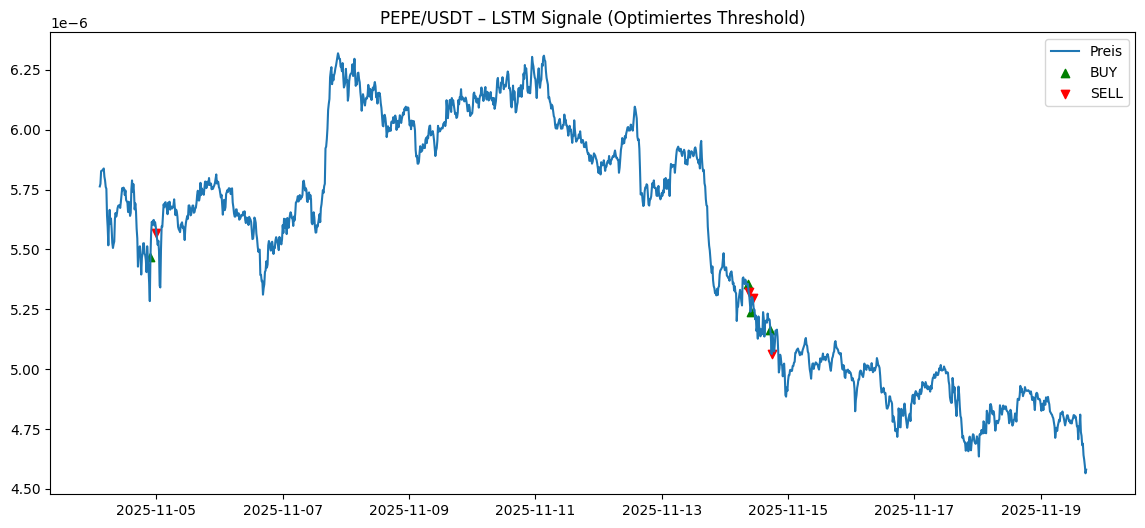

In [9]:
!pip install ccxt ta tensorflow

import ccxt
import pandas as pd
import numpy as np
import ta
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# === SETTINGS ===
coin = "PEPE/USDT"
# timeframe = "30m"
# limit = 12000
# seq_len = 5
exchange = ccxt.kucoin()

# === Daten abrufen ===
ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
df['time'] = pd.to_datetime(df['time'], unit='ms')

# === Indikatoren ===
df['rsi'] = ta.momentum.RSIIndicator(df['close'], 14).rsi()
df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], 14).average_true_range()
df['ma20'] = df['close'].rolling(20).mean()
df['ma50'] = df['close'].rolling(50).mean()
df['ma_diff'] = (df['ma20'] - df['ma50']) / df['ma50']
df['vol_change'] = df['volume'].pct_change()

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

# === Feature-Matrix ===
features = ['close','volume','rsi','atr','ma_diff','vol_change']
scaler = StandardScaler()
scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features)

# === Sequenzen vorbereiten ===
X = []
for i in range(seq_len, len(scaled_df)):
    X.append(scaled_df.iloc[i - seq_len:i].values)
X = np.array(X)

# === Modell laden ===
model = load_model("ml_model_lstm_meme_kucoin.keras")
preds = model.predict(X, verbose=0)

# === Test verschiedener Thresholds ===
thresholds = np.arange(0.3, 0.71, 0.05)
best_balance = 0
best_thresh = 0
best_trades = None

for thresh in thresholds:
    df_test = df.iloc[seq_len:].copy()
    df_test['signal'] = (preds > thresh).astype(int)

    balance = 100
    position = None
    entry_price = 0
    trades = []

    for i in range(len(df_test)):
        price = df_test.iloc[i]['close']
        signal = df_test.iloc[i]['signal']

        if position is None and signal == 1:
            position = 'LONG'
            entry_price = price
            trades.append({'time': df_test.iloc[i]['time'], 'action': 'BUY', 'price': price, 'balance': balance})
        elif position == 'LONG' and signal == 0:
            profit_pct = (price - entry_price) / entry_price
            balance *= (1 + profit_pct)
            trades.append({'time': df_test.iloc[i]['time'], 'action': 'SELL', 'price': price,
                           'profit_%': profit_pct*100, 'balance': balance})
            position = None

    if balance > best_balance:
        best_balance = balance
        best_thresh = thresh
        best_trades = trades

# === Ergebnisse anzeigen ===
trades_df = pd.DataFrame(best_trades)
print(f"✅ Optimale Schwelle: {best_thresh}")
print(f"Endbalance: {best_balance:.2f} USDT (Start: 100 USDT)")
print(trades_df.tail())

# === Plot ===
plt.figure(figsize=(14,6))
plt.plot(df['time'], df['close'], label='Preis')
buy_points = trades_df[trades_df['action']=='BUY']
sell_points = trades_df[trades_df['action']=='SELL']
plt.scatter(buy_points['time'], buy_points['price'], color='green', label='BUY', marker='^')
plt.scatter(sell_points['time'], sell_points['price'], color='red', label='SELL', marker='v')
plt.title(f"{coin} – LSTM Signale (Optimiertes Threshold)")
plt.legend()
plt.show()


#### mehrere coins


🔹 Backtest für DOGE/USDT


/tmp/ipython-input-210994886.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-210994886.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


                  time action    price      amount     balance  profit_usdt
9  2025-11-07 16:45:00   SELL  0.17428         NaN  105.963867     1.635459
10 2025-11-14 18:00:00    BUY  0.16320  306.372549  105.963867          NaN
11 2025-11-14 19:30:00   SELL  0.16265         NaN  105.795362    -0.168505
12 2025-11-14 21:00:00    BUY  0.16005  312.402374  105.795362          NaN
13 2025-11-14 21:45:00   SELL  0.16016         NaN  105.829726     0.034364
Endbalance: 105.83 USDT | Optimale Schwelle: 0.44999999999999996 | Trades: 7


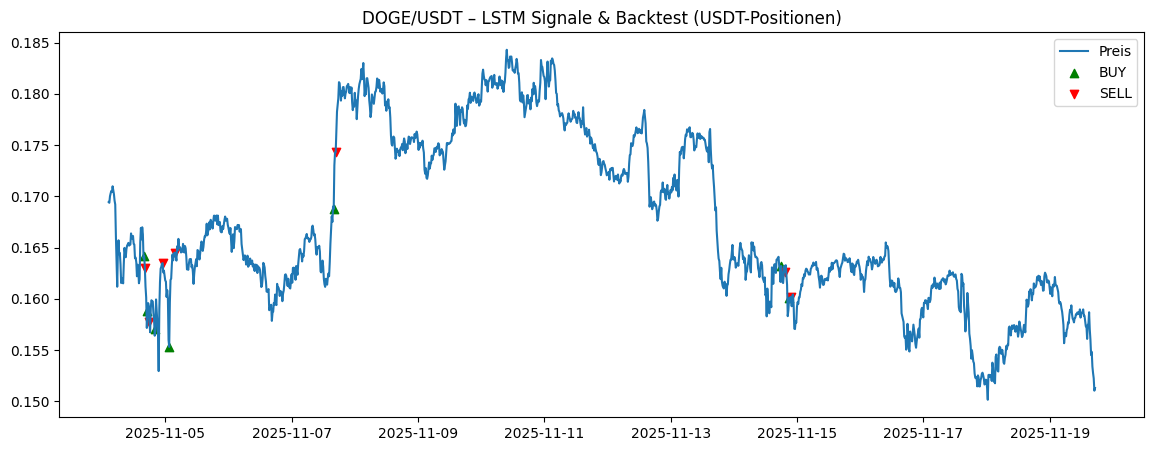


🔹 Backtest für SHIB/USDT


/tmp/ipython-input-210994886.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-210994886.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


                  time action     price        amount     balance  profit_usdt
53 2025-11-17 03:00:00   SELL  0.000009           NaN  105.731277     0.596243
54 2025-11-17 16:15:00    BUY  0.000009  5.625563e+06  105.731277          NaN
55 2025-11-17 23:00:00   SELL  0.000009           NaN  103.790458    -1.940819
56 2025-11-18 02:45:00    BUY  0.000009  5.781015e+06  103.790458          NaN
57 2025-11-18 09:45:00   SELL  0.000009           NaN  104.622924     0.832466
Endbalance: 104.62 USDT | Optimale Schwelle: 0.3 | Trades: 29


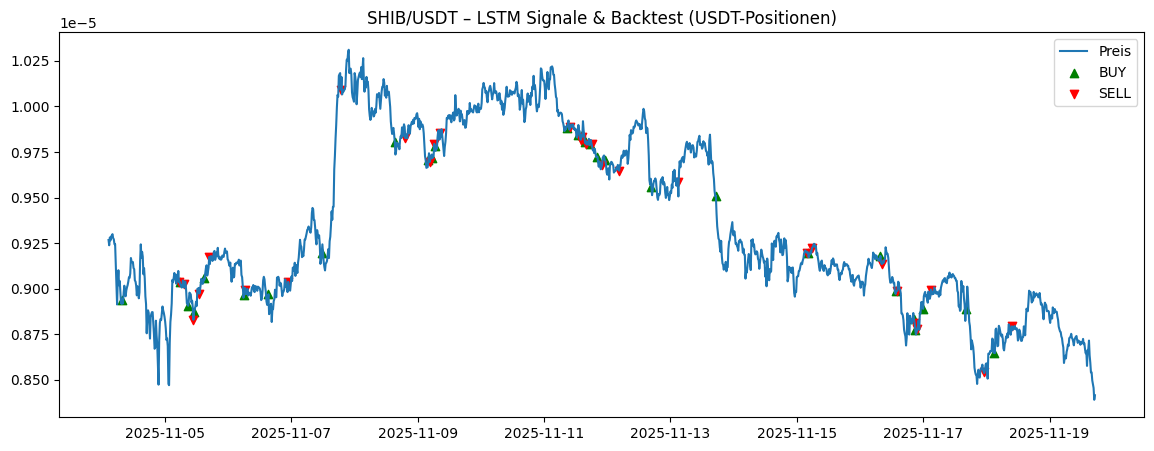


🔹 Backtest für PEPE/USDT


/tmp/ipython-input-210994886.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-210994886.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


                  time action     price        amount     balance  profit_usdt
45 2025-11-18 00:00:00   SELL  0.000005           NaN   99.632751     0.138504
46 2025-11-18 03:00:00    BUY  0.000005  1.055298e+07   99.632751          NaN
47 2025-11-18 07:00:00   SELL  0.000005           NaN   99.938787     0.306036
48 2025-11-18 07:15:00    BUY  0.000005  1.045151e+07   99.938787          NaN
49 2025-11-18 09:00:00   SELL  0.000005           NaN  100.377751     0.438963
Endbalance: 100.38 USDT | Optimale Schwelle: 0.3 | Trades: 25


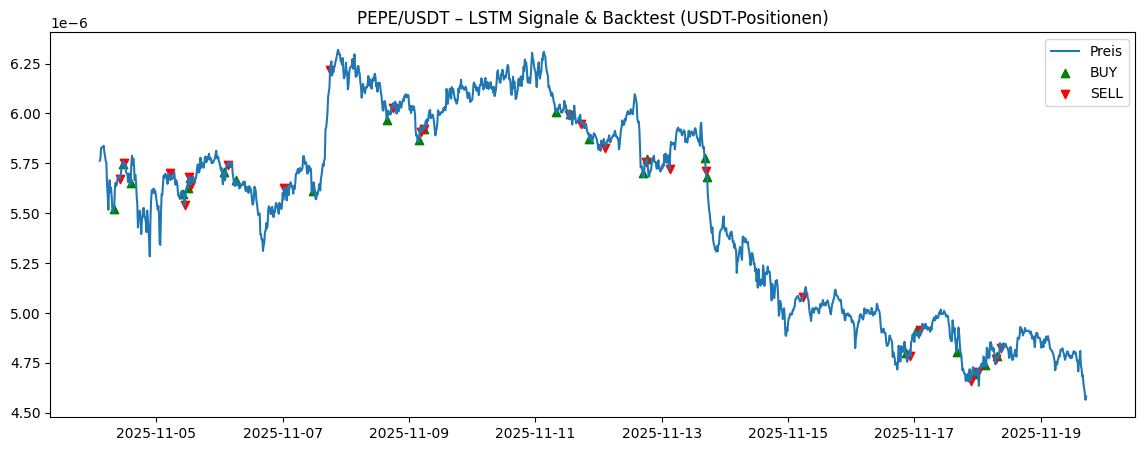


🔹 Backtest für BONK/USDT


/tmp/ipython-input-210994886.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-210994886.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


                  time action    price        amount     balance  profit_usdt
47 2025-11-17 21:00:00   SELL  0.00001           NaN  106.980749    -1.582035
48 2025-11-18 05:15:00    BUY  0.00001  4.833720e+06  106.980749          NaN
49 2025-11-18 06:30:00   SELL  0.00001           NaN  106.308862    -0.671887
50 2025-11-18 08:00:00    BUY  0.00001  4.887586e+06  106.308862          NaN
51 2025-11-18 08:45:00   SELL  0.00001           NaN  106.763408     0.454545
Endbalance: 106.76 USDT | Optimale Schwelle: 0.3 | Trades: 26


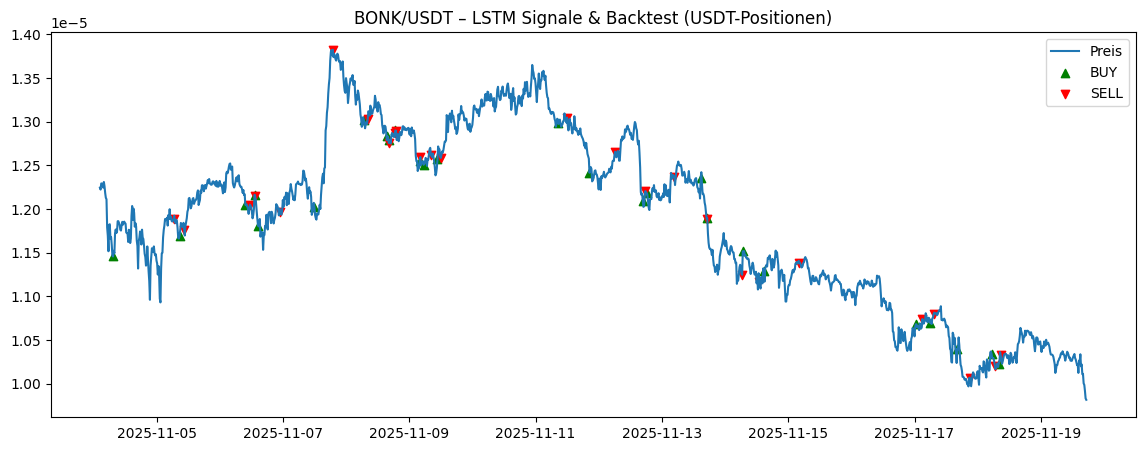


✅ Zusammenfassung aller Meme-Coins:
        coin  end_balance  best_threshold  num_trades
0  DOGE/USDT   105.829726            0.45           7
1  SHIB/USDT   104.622924            0.30          29
2  PEPE/USDT   100.377751            0.30          25
3  BONK/USDT   106.763408            0.30          26


In [10]:
import ccxt
import pandas as pd
import numpy as np
import ta
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# === SETTINGS ===
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
# timeframe = "30m"
# limit = 500
# seq_len = 5
exchange = ccxt.kucoin()
model_path = "ml_model_lstm_meme_kucoin.h5"
position_size_usdt = 50  # USDT pro Trade

# === Modell laden ===
model = load_model(model_path)

# Ergebnisliste
results = []

for coin in coins:
    print(f"\n🔹 Backtest für {coin}")
    try:
        # --- Daten abrufen ---
        ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')

        # --- Indikatoren ---
        df['rsi'] = ta.momentum.RSIIndicator(df['close'], 14).rsi()
        df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], 14).average_true_range()
        df['ma20'] = df['close'].rolling(20).mean()
        df['ma50'] = df['close'].rolling(50).mean()
        df['ma_diff'] = (df['ma20'] - df['ma50']) / df['ma50']
        df['vol_change'] = df['volume'].pct_change()

        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(method='bfill', inplace=True)
        df.fillna(method='ffill', inplace=True)
        df.dropna(inplace=True)

        # --- Features ---
        features = ['close','volume','rsi','atr','ma_diff','vol_change']
        scaler = StandardScaler()
        scaled = scaler.fit_transform(df[features])
        scaled_df = pd.DataFrame(scaled, columns=features)

        # --- Sequenzen ---
        X = []
        for i in range(seq_len, len(scaled_df)):
            X.append(scaled_df.iloc[i - seq_len:i].values)
        X = np.array(X)

        # --- Vorhersagen ---
        preds = model.predict(X, verbose=0)

        # --- Threshold-Optimierung ---
        thresholds = np.arange(0.3, 0.71, 0.05)
        best_balance = 100
        best_thresh = 0
        best_trades = None

        for thresh in thresholds:
            df_test = df.iloc[seq_len:].copy()
            df_test['signal'] = (preds > thresh).astype(int)
            balance = 100
            position = None
            entry_price = 0
            entry_amount = 0
            trades = []

            for i in range(len(df_test)):
                price = df_test.iloc[i]['close']
                signal = df_test.iloc[i]['signal']

                # Buy
                if position is None and signal == 1:
                    position = 'LONG'
                    entry_price = price
                    entry_amount = position_size_usdt / price  # Menge Coins kaufen
                    trades.append({'time': df_test.iloc[i]['time'], 'action':'BUY',
                                   'price':price, 'amount':entry_amount, 'balance':balance})

                # Sell
                elif position == 'LONG' and signal == 0:
                    exit_price = price
                    profit_usdt = (exit_price - entry_price) * entry_amount
                    balance += profit_usdt
                    trades.append({'time': df_test.iloc[i]['time'], 'action':'SELL',
                                   'price':exit_price, 'profit_usdt':profit_usdt, 'balance':balance})
                    position = None

            if balance > best_balance:
                best_balance = balance
                best_thresh = thresh
                best_trades = trades

        # --- Ergebnisse speichern ---
        trades_df = pd.DataFrame(best_trades)
        results.append({'coin': coin, 'end_balance': best_balance, 'best_threshold': best_thresh,
                        'num_trades': len(trades_df)//2})

        print(trades_df.tail())
        print(f"Endbalance: {best_balance:.2f} USDT | Optimale Schwelle: {best_thresh} | Trades: {len(trades_df)//2}")

        # --- Chart ---
        plt.figure(figsize=(14,5))
        plt.plot(df['time'], df['close'], label='Preis')
        buy_points = trades_df[trades_df['action']=='BUY']
        sell_points = trades_df[trades_df['action']=='SELL']
        plt.scatter(buy_points['time'], buy_points['price'], color='green', label='BUY', marker='^')
        plt.scatter(sell_points['time'], sell_points['price'], color='red', label='SELL', marker='v')
        plt.title(f"{coin} – LSTM Signale & Backtest (USDT-Positionen)")
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error with {coin}: {e}")

# --- Übersicht aller Coins ---
summary_df = pd.DataFrame(results)
print("\n✅ Zusammenfassung aller Meme-Coins:")
print(summary_df)


### v3.0

In [5]:
# auto_threshold_backtest.py
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import math

# ---------- CONFIG (anpassen falls nötig) ----------
# Muss mit den Parametern deiner Trainingspipeline übereinstimmen:
seq_len = 16
target_horizons = [3, 6, 12]   # dieselben Horizonte wie beim Labeling
pos_threshold = 0.01
min_volatility = 0.0005
use_atr_normalization = True
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]  # gleiche Reihenfolge wie vorher
split_ratio = 0.8

# Backtest params
initial_capital = 10000.0     # Startkapital in USD
risk_per_trade = 0.01         # Fraction of capital risked per trade (position sizing placeholder)
slippage_pct = 0.0005         # 0.05% slippage per side
fee_pct = 0.001               # 0.1% taker fee per side
cooldown_bars = 0             # bars to skip after a trade (0 = none)
optimize_for = "profit"       # "profit" or "f1" to select best threshold

# ---------- INPUTS (aus deinem Training/Prediction) ----------
# - probs: numpy array of predicted probabilities (model.predict(X_test_scaled).flatten())
# - y_test: numpy array of true binary labels for the test set
# - df_coins: dict mapping coin -> dataframe used earlier (must include 'close' column)
# These three must exist in the environment you're running this in.

# Sanity check
assert 'probs' in globals(), "Variable 'probs' not found. Run model.predict(X_test_scaled) first and assign to 'probs'."
assert 'y_test' in globals(), "Variable 'y_test' not found. Make sure y_test from your pipeline is available."
assert 'df_coins' in globals(), "Variable 'df_coins' not found. Provide the dict of per-coin dataframes used earlier."

# ---------- Helpers: rebuild test metadata in same concatenation order ----------
def build_test_metadata_per_coin(df, seq_len, target_horizons, pos_threshold, min_volatility, use_atr_normalization):
    """
    Returns arrays:
      entry_indices: list of int (index i of df that corresponds to sequence end / entry)
      entry_prices: close price at i (we will use next bar open if available in backtest)
      future_price_matrix: list of arrays of future closes up to max_horizon (for exit simulation)
    """
    prices = df['close'].values
    atr = df['atr'].values if 'atr' in df.columns else np.zeros(len(df))
    n = len(df)
    entry_indices = []
    entry_prices = []
    future_matrix = []  # each element: array of future closes for horizons up to max_horizon

    max_h = max(target_horizons)
    for i in range(seq_len, n):
        # volatility filter
        vol_rel = (atr[i] / (prices[i] + 1e-9)) if (i < len(atr) and atr[i] > 0) else 0.0
        if vol_rel < min_volatility:
            # still keep entry (we will have same labeling rules earlier), but we can mark filtered if desired
            pass

        # collect entry and future prices up to max_h
        entry_indices.append(i)
        entry_prices.append(prices[i])
        # future closes from i+1 .. i+max_h (if available)
        fut = []
        for k in range(1, max_h + 1):
            idx = i + k
            if idx < n:
                fut.append(prices[idx])
            else:
                fut.append(np.nan)
        future_matrix.append(np.array(fut))
    return np.array(entry_indices), np.array(entry_prices), np.array(future_matrix)

# Build metadata lists in same order your pipeline concatenated X_test
meta_coins = []
meta_entry_indices = []
meta_entry_prices = []
meta_future_matrix = []  # list of arrays

for coin in coins:
    if coin not in df_coins:
        continue
    df = df_coins[coin]
    # compute candidates same as in the pipeline; skip sequences that pipeline skipped (len < threshold)
    # We assume pipeline used get_dummies(coin) and built sequences only if len >= threshold. We'll mimic that.
    entry_idx, entry_p, fut_mat = build_test_metadata_per_coin(df, seq_len, target_horizons, pos_threshold, min_volatility, use_atr_normalization)
    if len(entry_idx) < 1:
        continue
    # split per coin same way as training: first 80% -> train, last 20% -> test
    split_idx = int(split_ratio * len(entry_idx))
    # Only append the test slice (same order as X_test concatenation)
    test_entry_idx = entry_idx[split_idx:]
    test_entry_p = entry_p[split_idx:]
    test_fut = fut_mat[split_idx:]
    # extend global lists
    meta_coins.extend([coin] * len(test_entry_idx))
    meta_entry_indices.extend(test_entry_idx.tolist())
    meta_entry_prices.extend(test_entry_p.tolist())
    meta_future_matrix.extend([row for row in test_fut])

# convert to arrays
meta_coins = np.array(meta_coins)
meta_entry_indices = np.array(meta_entry_indices)
meta_entry_prices = np.array(meta_entry_prices)
meta_future_matrix = np.array(meta_future_matrix)  # shape (N_test, max_h)

# Now we expect len(probs) == len(y_test) == len(meta_entry_prices)
assert len(probs) == len(y_test) == len(meta_entry_prices), f"Length mismatch: probs {len(probs)}, y_test {len(y_test)}, meta_entries {len(meta_entry_prices)}"

# ---------- Backtest logic ----------
def simulate_trades_for_threshold(threshold, probs, meta_entry_prices, meta_future_matrix,
                                  pos_threshold=0.01, slippage_pct=0.0005, fee_pct=0.001,
                                  initial_capital=10000.0, risk_per_trade=0.01, cooldown_bars=0):
    """
    For each prediction where prob >= threshold, simulate:
     - entry at next bar price if available (meta_future_matrix[:,0]), else entry at entry_price
     - look for first future bar (within max_h) that gives pos_threshold return, or exit at max_h bar
    """
    capital = initial_capital
    num_trades = 0
    total_profit_loss = 0.0
    current_cooldown = 0

    for i in range(len(probs)):
        if probs[i] >= threshold and current_cooldown == 0:
            num_trades += 1
            entry_price = meta_entry_prices[i] * (1 + slippage_pct + fee_pct) # Simulate entry with slippage and fee

            # Simulate exit
            future_prices = meta_future_matrix[i]
            exit_price = np.nan

            # Look for target return within horizons or exit at max_h
            for j, fut_price in enumerate(future_prices):
                if np.isnan(fut_price): # If no future price data
                    break
                if (fut_price - entry_price) / entry_price > pos_threshold:
                    exit_price = fut_price * (1 - slippage_pct - fee_pct) # Simulate exit with slippage and fee
                    break

            if np.isnan(exit_price) and not np.isnan(future_prices[-1]): # Exit at last available future price
                exit_price = future_prices[-1] * (1 - slippage_pct - fee_pct)

            if not np.isnan(exit_price): # Calculate PnL if trade occurred
                profit_loss = (exit_price - entry_price) # Per unit profit/loss
                capital += profit_loss # Simplified for backtesting, without position sizing
                total_profit_loss += profit_loss

            current_cooldown = cooldown_bars
        elif current_cooldown > 0:
            current_cooldown -= 1

    return capital, num_trades, total_profit_loss

# === Threshold Optimization ===
thresholds = np.arange(0.3, 0.71, 0.01)
best_threshold = 0
best_metric_value = -np.inf # can be profit or f1-score
best_accuracy = 0
best_precision = 0
best_recall = 0

print("Optimizing threshold...")
for thresh in thresholds:
    preds_thresh = (probs >= thresh).astype(int)

    # Calculate classification metrics
    if len(np.unique(preds_thresh)) < 2: # Handle cases where only one class is predicted
        current_f1 = 0.0
        current_acc = accuracy_score(y_test, preds_thresh)
        current_prec = precision_score(y_test, preds_thresh, zero_division=0)
        current_rec = recall_score(y_test, preds_thresh, zero_division=0)
    else:
        current_f1 = f1_score(y_test, preds_thresh)
        current_acc = accuracy_score(y_test, preds_thresh)
        current_prec = precision_score(y_test, preds_thresh)
        current_rec = recall_score(y_test, preds_thresh)

    # Simulate trades for the current threshold
    final_capital, trades_count, total_pnl = simulate_trades_for_threshold(
        thresh, probs, meta_entry_prices, meta_future_matrix,
        pos_threshold=pos_threshold, slippage_pct=slippage_pct, fee_pct=fee_pct,
        initial_capital=initial_capital, risk_per_trade=risk_per_trade, cooldown_bars=cooldown_bars
    )

    current_profit_percentage = (final_capital - initial_capital) / initial_capital

    if optimize_for == "profit":
        metric_to_optimize = current_profit_percentage
    else: # optimize_for == "f1"
        metric_to_optimize = current_f1

    if metric_to_optimize > best_metric_value:
        best_metric_value = metric_to_optimize
        best_threshold = thresh
        best_accuracy = current_acc
        best_precision = current_prec
        best_recall = current_rec

# --- Final Results ---
print(f"\n✅ Optimized Threshold: {best_threshold:.2f}")

# Run backtest with the best threshold for final metrics
preds_best = (probs >= best_threshold).astype(int)
final_capital, trades_count, total_pnl = simulate_trades_for_threshold(
    best_threshold, probs, meta_entry_prices, meta_future_matrix,
    pos_threshold=pos_threshold, slippage_pct=slippage_pct, fee_pct=fee_pct,
    initial_capital=initial_capital, risk_per_trade=risk_per_trade, cooldown_bars=cooldown_bars
)

print(f"Initial Capital: {initial_capital:.2f} USD")
print(f"Final Capital: {final_capital:.2f} USD")
print(f"Total PnL: {total_pnl:.2f} USD")
print(f"Total Trades: {trades_count}")
print(f"Profit/Loss Percentage: {((final_capital - initial_capital) / initial_capital * 100):.2f}%")
print(f"Accuracy (on test set with best threshold): {best_accuracy:.4f}")
print(f"Precision (on test set with best threshold): {best_precision:.4f}")
print(f"Recall (on test set with best threshold): {best_recall:.4f}")
print(f"F1-Score (on test set with best threshold): {f1_score(y_test, preds_best):.4f}")
print("Classification Report (on test set with best threshold):\n", classification_report(y_test, preds_best))

Optimizing threshold...

✅ Optimized Threshold: 0.53
Initial Capital: 10000.00 USD
Final Capital: 10000.05 USD
Total PnL: 0.05 USD
Total Trades: 501
Profit/Loss Percentage: 0.00%
Accuracy (on test set with best threshold): 0.5556
Precision (on test set with best threshold): 0.3752
Recall (on test set with best threshold): 0.4665
F1-Score (on test set with best threshold): 0.4159
Classification Report (on test set with best threshold):
               precision    recall  f1-score   support

           0       0.69      0.60      0.64       785
           1       0.38      0.47      0.42       403

    accuracy                           0.56      1188
   macro avg       0.53      0.53      0.53      1188
weighted avg       0.58      0.56      0.56      1188



In [10]:
# auto_threshold_backtest.py
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import math

# ---------- CONFIG (anpassen falls nötig) ----------
# Muss mit den Parametern deiner Trainingspipeline übereinstimmen:
seq_len = 16
target_horizons = [3, 6, 12]   # dieselben Horizonte wie beim Labeling
pos_threshold = 0.01
min_volatility = 0.0005
use_atr_normalization = True
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]  # gleiche Reihenfolge wie vorher
split_ratio = 0.8

# Backtest params
initial_capital = 10000.0     # Startkapital in USD
risk_per_trade = 0.01         # Fraction of capital risked per trade (position sizing placeholder)
slippage_pct = 0.0005         # 0.05% slippage per side
fee_pct = 0.001               # 0.1% taker fee per side
cooldown_bars = 0             # bars to skip after a trade (0 = none)
optimize_for = "profit"       # "profit" or "f1" to select best threshold

# ---------- INPUTS (aus deinem Training/Prediction) ----------
# - probs: numpy array of predicted probabilities (model.predict(X_test_scaled).flatten())
# - y_test: numpy array of true binary labels for the test set
# - df_coins: dict mapping coin -> dataframe used earlier (must include 'close' column)
# These three must exist in the environment you're running this in.

# Sanity check
assert 'probs' in globals(), "Variable 'probs' not found. Run model.predict(X_test_scaled) first and assign to 'probs'."
assert 'y_test' in globals(), "Variable 'y_test' not found. Make sure y_test from your pipeline is available."
assert 'df_coins' in globals(), "Variable 'df_coins' not found. Provide the dict of per-coin dataframes used earlier."

# ---------- Helpers: rebuild test metadata in same concatenation order ----------
def build_test_metadata_per_coin(df, seq_len, target_horizons, pos_threshold, min_volatility, use_atr_normalization):
    """
    Returns arrays:
      entry_indices: list of int (index i of df that corresponds to sequence end / entry)
      entry_prices: close price at i (we will use next bar open if available in backtest)
      future_price_matrix: list of arrays of future closes up to max_horizon (for exit simulation)
    """
    prices = df['close'].values
    atr = df['atr'].values if 'atr' in df.columns else np.zeros(len(df))
    n = len(df)
    entry_indices = []
    entry_prices = []
    future_matrix = []  # each element: array of future closes for horizons up to max_horizon

    max_h = max(target_horizons)
    for i in range(seq_len, n):
        # volatility filter
        vol_rel = (atr[i] / (prices[i] + 1e-9)) if (i < len(atr) and atr[i] > 0) else 0.0
        if vol_rel < min_volatility:
            # still keep entry (we will have same labeling rules earlier), but we can mark filtered if desired
            pass

        # collect entry and future prices up to max_h
        entry_indices.append(i)
        entry_prices.append(prices[i])
        # future closes from i+1 .. i+max_h (if available)
        fut = []
        for k in range(1, max_h + 1):
            idx = i + k
            if idx < n:
                fut.append(prices[idx])
            else:
                fut.append(np.nan)
        future_matrix.append(np.array(fut))
    return np.array(entry_indices), np.array(entry_prices), np.array(future_matrix)

# Build metadata lists in same order your pipeline concatenated X_test
meta_coins = []
meta_entry_indices = []
meta_entry_prices = []
meta_future_matrix = []  # list of arrays

for coin in coins:
    if coin not in df_coins:
        continue
    df = df_coins[coin]
    # compute candidates same as in the pipeline; skip sequences that pipeline skipped (len < threshold)
    # We assume pipeline used get_dummies(coin) and built sequences only if len >= threshold. We'll mimic that.
    entry_idx, entry_p, fut_mat = build_test_metadata_per_coin(df, seq_len, target_horizons, pos_threshold, min_volatility, use_atr_normalization)
    if len(entry_idx) < 1:
        continue
    # split per coin same way as training: first 80% -> train, last 20% -> test
    split_idx = int(split_ratio * len(entry_idx))
    # Only append the test slice (same order as X_test concatenation)
    test_entry_idx = entry_idx[split_idx:]
    test_entry_p = entry_p[split_idx:]
    test_fut = fut_mat[split_idx:]
    # extend global lists
    meta_coins.extend([coin] * len(test_entry_idx))
    meta_entry_indices.extend(test_entry_idx.tolist())
    meta_entry_prices.extend(test_entry_p.tolist())
    meta_future_matrix.extend([row for row in test_fut])

# convert to arrays
meta_coins = np.array(meta_coins)
meta_entry_indices = np.array(meta_entry_indices)
meta_entry_prices = np.array(meta_entry_prices)
meta_future_matrix = np.array(meta_future_matrix)  # shape (N_test, max_h)

# Now we expect len(probs) == len(y_test) == len(meta_entry_prices)
assert len(probs) == len(y_test) == len(meta_entry_prices), f"Length mismatch: probs {len(probs)}, y_test {len(y_test)}, meta_entries {len(meta_entry_prices)}"

# ---------- Backtest logic ----------
def simulate_trades_for_threshold(threshold, probs, meta_entry_prices, meta_future_matrix,
                                  pos_threshold=0.01, slippage_pct=0.0005, fee_pct=0.001,
                                  initial_capital=10000.0, risk_per_trade=0.01, cooldown_bars=0):
    """
    For each prediction where prob >= threshold, simulate:
     - entry at next bar price if available (meta_future_matrix[:,0]), else entry at entry_price
     - look for first future bar (within max_horizon) where price >= entry*(1+pos_threshold) -> take profit there
     - otherwise exit at last horizon price
     - compute PnL net of fees+slippage
    Returns a DataFrame of trades and aggregate metrics.
    """
    N = len(probs)
    trades = []
    capital = initial_capital
    last_trade_idx = -9999

    max_h = meta_future_matrix.shape[1]
    for i in range(N):
        p = probs[i]
        if p < threshold:
            continue
        # respect cooldown: skip if within cooldown_bars since last_trade_idx
        if cooldown_bars > 0 and (i - last_trade_idx) <= cooldown_bars:
            continue

        # determine entry price: use next bar close if available (meta_future_matrix[i,0]), else use entry price
        entry_price = meta_future_matrix[i, 0] if not np.isnan(meta_future_matrix[i, 0]) else meta_entry_prices[i]
        if math.isnan(entry_price):
            continue

        # position size (units) = risk_per_trade * capital / (entry_price)  (simple sizing)
        position_value = capital * risk_per_trade
        qty = position_value / entry_price

        # search for TP within horizon
        exit_price = None
        exit_bar_offset = None
        target_price = entry_price * (1.0 + pos_threshold)
        for h in range(max_h):
            fut_p = meta_future_matrix[i, h]
            if np.isnan(fut_p):
                continue
            if fut_p >= target_price:
                exit_price = fut_p
                exit_bar_offset = h + 1
                break
        # if no TP hit, exit at last available future price
        if exit_price is None:
            # take last non-nan within future matrix
            futs = meta_future_matrix[i]
            valid = futs[~np.isnan(futs)]
            if len(valid) == 0:
                continue
            exit_price = valid[-1]
            exit_bar_offset = len(valid)

        # apply slippage & fees (entry + exit)
        # assume slippage and fees applied as % of price on both sides
        entry_effective = entry_price * (1.0 + slippage_pct + fee_pct)
        exit_effective = exit_price * (1.0 - slippage_pct - fee_pct)

        pnl = (exit_effective - entry_effective) * qty
        ret_pct = pnl / (position_value + 1e-9)

        # update capital (simple: add pnl)
        capital += pnl

        trade = {
            'idx': i,
            'prob': p,
            'entry_price': entry_price,
            'exit_price': exit_price,
            'exit_offset_bars': exit_bar_offset,
            'qty': qty,
            'pnl': pnl,
            'ret_pct': ret_pct,
            'capital': capital
        }
        trades.append(trade)
        last_trade_idx = i

    trades_df = pd.DataFrame(trades)
    # compute aggregate metrics
    total_trades = len(trades_df)
    total_pnl = trades_df['pnl'].sum() if total_trades > 0 else 0.0
    win_rate = (trades_df['pnl'] > 0).mean() if total_trades > 0 else 0.0
    avg_pnl = trades_df['pnl'].mean() if total_trades > 0 else 0.0

    # equity curve returns per trade
    returns = np.array([]) # Initialize as empty array
    if total_trades > 0:
        returns = trades_df['ret_pct'].fillna(0).values

    if len(returns) > 1:
        sharpe = (np.mean(returns) / (np.std(returns) + 1e-9)) * np.sqrt(252 * (24*4))  # rough annualization for 15m bars
    else:
        sharpe = 0.0

    results = {
        'threshold': threshold,
        'trades': trades_df,
        'total_trades': total_trades,
        'total_pnl': total_pnl,
        'win_rate': win_rate,
        'avg_pnl': avg_pnl,
        'final_capital': capital,
        'sharpe': sharpe
    }
    return results

# ---------- Threshold scan ----------
thresholds = np.arange(0.01, 0.96, 0.01)  # 0.01 .. 0.95
scan_results = []

# Precompute classification metrics for each threshold as well
for thr in thresholds:
    preds_thr = (probs >= thr).astype(int)
    # basic classification metrics
    acc = accuracy_score(y_test, preds_thr)
    prec = precision_score(y_test, preds_thr, zero_division=0)
    rec = recall_score(y_test, preds_thr, zero_division=0)
    f1 = f1_score(y_test, preds_thr, zero_division=0)
    auc = roc_auc_score(y_test, probs)
    cm = confusion_matrix(y_test, preds_thr)
    # simulate econ trades
    bt = simulate_trades_for_threshold(thr, probs, meta_entry_prices, meta_future_matrix,
                                       pos_threshold=pos_threshold, slippage_pct=slippage_pct, fee_pct=fee_pct,
                                       initial_capital=initial_capital, risk_per_trade=risk_per_trade, cooldown_bars=cooldown_bars)
    scan_results.append({
        'threshold': thr,
        'acc': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc,
        'total_trades': bt['total_trades'],
        'total_pnl': bt['total_pnl'],
        'final_capital': bt['final_capital'],
        'win_rate': bt['win_rate'],
        'avg_pnl': bt['avg_pnl'],
        'sharpe': bt['sharpe'],
        'bt_obj': bt  # keep object for later inspection
    })

scan_df = pd.DataFrame(scan_results)
# choose best threshold
if optimize_for == "profit":
    best_row = scan_df.loc[scan_df['total_pnl'].idxmax()]
else:
    best_row = scan_df.loc[scan_df['f1'].idxmax()]

best_thr = best_row['threshold']
print("Best threshold chosen:", best_thr)
print(best_row[['threshold','total_trades','total_pnl','final_capital','win_rate','sharpe','f1','precision','recall']])

# show confusion matrix + classification metrics at best_thr
best_preds = (probs >= best_thr).astype(int)
print("Confusion Matrix at best threshold:\n", confusion_matrix(y_test, best_preds))
print("Classification report (best threshold):")
from sklearn.metrics import classification_report
print(classification_report(y_test, best_preds, digits=4))

# show trade summary and equity curve
best_bt = best_row['bt_obj']
trades_df = best_bt['trades']
if not trades_df.empty:
    trades_df = trades_df.reset_index(drop=True)
    trades_df['cum_capital'] = trades_df['capital']
    print("\nTop 10 trades:")
    print(trades_df[['idx','prob','entry_price','exit_price','exit_offset_bars','pnl','capital']].head(10))
    # equity curve
    equity = trades_df['cum_capital'].values
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,4))
    plt.plot(equity)
    plt.title(f'Equity curve (threshold={best_thr:.2f})')
    plt.xlabel('trade number')
    plt.ylabel('capital')
    plt.grid(True)
    plt.show()
else:
    print("No trades executed at best threshold.")

# Save scan summary
scan_df.to_csv("threshold_scan_results.csv", index=False)
print("Threshold scan results saved to threshold_scan_results.csv")

Best threshold chosen: 0.9400000000000001
threshold           0.94
total_trades           0
total_pnl            0.0
final_capital    10000.0
win_rate             0.0
sharpe               0.0
f1                   0.0
precision            0.0
recall               0.0
Name: 93, dtype: object
Confusion Matrix at best threshold:
 [[785   0]
 [403   0]]
Classification report (best threshold):
              precision    recall  f1-score   support

           0     0.6608    1.0000    0.7957       785
           1     0.0000    0.0000    0.0000       403

    accuracy                         0.6608      1188
   macro avg     0.3304    0.5000    0.3979      1188
weighted avg     0.4366    0.6608    0.5258      1188

No trades executed at best threshold.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Threshold scan results saved to threshold_scan_results.csv


/tmp/ipython-input-1798820022.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-1798820022.py:107: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-1798820022.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-1798820022.py:107: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-1798820022.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Us

Shapes train/val/test: (4152, 16, 18) (892, 16, 18) (892, 16, 18)
Class weights: {np.int64(0): np.float64(0.7914601601219977), np.int64(1): np.float64(1.357750163505559)}
Train label dist: [2623 1529]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 16, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16, 128)   │      2,432 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 16, 128)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 16, 128)   │     66,048 │ add_3[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 16, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 16, 128)   │          0 │ add_3[0][0],      │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 16, 128)   │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16, 128)   │     32,896 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 16, 128)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 16, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 128)   │        256 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 16, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 16, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 16, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 128)   │        256 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16, 128)   │     32,896 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 16, 128)   │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 16, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_9[0][0] 

 Total params: 275,713 (1.05 MB)

 Trainable params: 275,713 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step - accuracy: 0.4503 - auc: 0.5154 - loss: 0.0977 - val_accuracy: 0.3285 - val_auc: 0.5357 - val_loss: 0.0704 - learning_rate: 0.0010
Epoch 2/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.3816 - auc: 0.5250 - loss: 0.0709 - val_accuracy: 0.3386 - val_auc: 0.5656 - val_loss: 0.0702 - learning_rate: 0.0010
Epoch 3/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.3870 - auc: 0.5466 - loss: 0.0704 - val_accuracy: 0.3184 - val_auc: 0.6123 - val_loss: 0.0700 - learning_rate: 0.0010
Epoch 4/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.3910 - auc: 0.5869 - loss: 0.0693 - val_accuracy: 0.3419 - val_auc: 0.6100 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 5/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.3800 - auc: 0.5884 - loss: 0.0689 - val_accuracy: 0.3285 - val_auc: 0.6043 - val_loss: 0.0720 - learning_rate: 0.0010
Epoch 6/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.3967 - auc: 

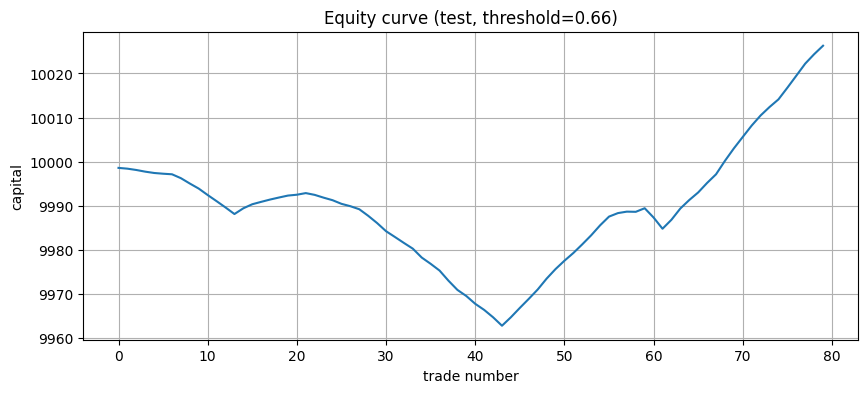

Saved model, scaler and scan CSVs.


In [11]:
# full_pipeline_transformer_pnl.py
# Full pipeline:
# 1) fetch per-coin data & features
# 2) improved labeling (multi-horizon + volatility filter + intensity)
# 3) per-coin chronological train/val/test split
# 4) scaler fit on train, apply to val/test
# 5) Transformer classifier trained with focal loss + sample_weight based on intensity (PnL-aware surrogate)
# 6) threshold tuning on VALIDATION (walk-forward style)
# 7) final backtest on TEST with SL + Trailing TP + next-open entries, fees+slippage
# 8) save model & artifacts

import os
import math
import random
import numpy as np
import pandas as pd
import ccxt
import ta
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K

# -------------------------
# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# === CONFIG ===
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
timeframe = '15m'
limit = 34560
seq_len = 16
target_horizons = [3, 6, 12]
pos_threshold = 0.01
min_volatility = 0.0005
use_atr_normalization = True

# Split fractions per coin
train_frac = 0.7
val_frac = 0.15
test_frac = 0.15

# Model / training
model_type = "transformer"
batch_size = 128
epochs = 40
learning_rate = 1e-3

# Backtest params
initial_capital = 10000.0
risk_per_trade = 0.01
slippage_pct = 0.0005
fee_pct = 0.001
stop_loss_pct = -0.01      # -1% stop
trailing_tp_pct = 0.02     # 2% trailing take profit initial (will trail)
cooldown_bars = 0

exchange = ccxt.kucoin()

# -------------------------
# Helpers: fetch & features
def fetch_and_featurize(coin, timeframe, limit):
    ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df.sort_values('time', inplace=True, ignore_index=True)

    # indicators
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
    df['ma20'] = df['close'].rolling(20).mean()
    df['ma50'] = df['close'].rolling(50).mean()
    df['ma_diff'] = (df['ma20'] - df['ma50']) / (df['ma50'] + 1e-9)
    df['vol_change'] = df['volume'].pct_change()

    macd = ta.trend.MACD(df['close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_hist'] = macd.macd_diff()

    stoch = ta.momentum.StochRSIIndicator(df['close'])
    df['stochrsi_k'] = stoch.stochrsi_k()
    df['stochrsi_d'] = stoch.stochrsi_d()

    df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()
    bb = ta.volatility.BollingerBands(df['close'], window=20, window_dev=2)
    df['bb_pct'] = (df['close'] - bb.bollinger_lband()) / (bb.bollinger_hband() - bb.bollinger_lband() + 1e-9)

    # vwap-like
    tp = (df['high'] + df['low'] + df['close']) / 3
    df['vwap_like'] = (tp * df['volume']).rolling(20).sum() / (df['volume'].rolling(20).sum() + 1e-9)
    df['vwap_dist'] = (df['close'] - df['vwap_like']) / (df['vwap_like'] + 1e-9)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.dropna(inplace=True)
    df['coin'] = coin
    return df

# Labeling (multi-horizon + volatility filter + intensity)
def build_labels(df, target_horizons, pos_threshold, min_volatility, use_atr_normalization):
    prices = df['close'].values
    atr = df['atr'].values if 'atr' in df.columns else np.zeros(len(df))
    n = len(df)
    lbl = np.zeros(n, dtype=int)
    intensity = np.zeros(n, dtype=float)

    max_h = max(target_horizons)
    for t in range(n):
        max_ret = 0.0
        for h in target_horizons:
            if t + h < n:
                window_max = np.max(prices[t+1:t+1+h]) if (t+1)<=t+h else prices[t]
                ret = (window_max - prices[t]) / (prices[t] + 1e-9)
                max_ret = max(max_ret, ret)
        vol_rel = atr[t] / (prices[t] + 1e-9) if atr[t] > 0 else 0.0
        if vol_rel < min_volatility:
            lbl[t] = 0
            intensity[t] = 0.0
            continue
        intensity[t] = (max_ret / (vol_rel + 1e-9)) if use_atr_normalization else max_ret
        lbl[t] = 1 if max_ret > pos_threshold else 0
    return lbl, intensity

# Build sequences and splits per coin
def build_sequences_for_coin(df, seq_len, features, target_horizons, pos_threshold, min_volatility, use_atr_normalization):
    lbl, intensity = build_labels(df, target_horizons, pos_threshold, min_volatility, use_atr_normalization)
    X, y, w = [], [], []
    # include coin one-hot
    df_onehot = pd.get_dummies(df, columns=['coin'])
    available_features = [f for f in features if f in df_onehot.columns] + [c for c in df_onehot.columns if c.startswith('coin_')]
    for i in range(seq_len, len(df_onehot)):
        X.append(df_onehot.iloc[i-seq_len:i][available_features].values)
        y.append(lbl[i])
        w.append(max(0.0, intensity[i]))  # non-negative sample weight surrogate
    return np.array(X), np.array(y), np.array(w), available_features

# Transformer components
def positional_encoding(seq_len, d_model):
    positions = np.arange(seq_len)[:, np.newaxis]
    dims = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (dims//2)) / np.float32(d_model))
    angle_rads = positions * angle_rates
    s = np.zeros(angle_rads.shape)
    s[:, 0::2] = np.sin(angle_rads[:, 0::2])
    s[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(s, dtype=tf.float32)

def build_transformer_classifier(seq_len, n_features, d_model=128, num_heads=4, ff_dim=256, num_blocks=2, dropout=0.2):
    inp = Input(shape=(seq_len, n_features))
    x = layers.Dense(d_model)(inp)
    pos_enc = positional_encoding(seq_len, d_model)
    x = x + pos_enc
    for _ in range(num_blocks):
        # Multi-head self-attention
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, dropout=dropout)(x, x)
        attn_output = layers.Dropout(dropout)(attn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        # Feed-forward
        ff = layers.Dense(ff_dim, activation='relu')(x)
        ff = layers.Dense(d_model)(ff)
        ff = layers.Dropout(dropout)(ff)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inp, out)
    return model

# Focal loss
def focal_loss(alpha=0.75, gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_true_f = tf.cast(y_true, tf.float32)
        eps = K.epsilon()
        y_pred = K.clip(y_pred, eps, 1. - eps)
        bce = - (y_true_f * K.log(y_pred) + (1 - y_true_f) * K.log(1 - y_pred))
        p_t = tf.where(tf.equal(y_true_f, 1), y_pred, 1 - y_pred)
        mod = K.pow(1.0 - p_t, gamma)
        a_t = y_true_f * alpha + (1 - y_true_f) * (1 - alpha)
        loss = a_t * mod * bce
        return K.mean(loss)
    return loss_fn

# -------------------------
# 1) Load data per coin, build sequences
features = [
    'close','open','high','low','volume','rsi','atr','ma_diff','vol_change',
    'macd','macd_signal','macd_hist','stochrsi_k','stochrsi_d','obv','bb_pct','vwap_dist'
]

coin_sequences = []
feature_list_reference = None

for coin in coins:
    try:
        df = fetch_and_featurize(coin, timeframe, limit)
    except Exception as e:
        print(f"Failed to fetch {coin}: {e}")
        continue
    Xc, yc, wc, feats = build_sequences_for_coin(df, seq_len, features, target_horizons, pos_threshold, min_volatility, use_atr_normalization)
    if len(Xc) == 0:
        print(f"Not enough data for {coin}")
        continue
    # chronological split per coin
    n = len(Xc)
    i1 = int(train_frac * n)
    i2 = int((train_frac + val_frac) * n)
    coin_sequences.append({
        'coin': coin, 'X': Xc, 'y': yc, 'w': wc, 'df': df, 'split_idx': (i1,i2)
    })
    feature_list_reference = feats  # last one is fine (same schema after get_dummies across coins)

# concatenate splits across coins
X_train_list, y_train_list, w_train_list = [], [], []
X_val_list, y_val_list, w_val_list = [], [], []
X_test_list, y_test_list, w_test_list = [], [], []

meta_test = []  # for backtest (coin, index_in_df, seq-end pos)

for seq in coin_sequences:
    Xc, yc, wc = seq['X'], seq['y'], seq['w']
    i1,i2 = seq['split_idx']
    X_train_list.append(Xc[:i1])
    y_train_list.append(yc[:i1])
    w_train_list.append(wc[:i1])
    X_val_list.append(Xc[i1:i2])
    y_val_list.append(yc[i1:i2])
    w_val_list.append(wc[i1:i2])
    X_test_list.append(Xc[i2:])
    y_test_list.append(yc[i2:])
    w_test_list.append(wc[i2:])
    # build meta_test entries for each test row: coin, seq_end_index in df, and entry prices
    df = seq['df']
    n = len(df)
    # entry indices correspond to sequence end position i in build_sequences
    start_idx = seq_len + i2
    for k in range(i2, len(Xc)):
        seq_end_idx = k + seq_len  # position in df corresponding to end
        meta_test.append({'coin': seq['coin'], 'seq_end_idx': seq_end_idx, 'df': df})

# combine
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
w_train = np.concatenate(w_train_list, axis=0)
X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)
w_val = np.concatenate(w_val_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)
w_test = np.concatenate(w_test_list, axis=0)

print("Shapes train/val/test:", X_train.shape, X_val.shape, X_test.shape)
n_features = X_train.shape[2]

# StandardScaler on flattened windows (fit on train)
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, n_features)
scaler.fit(X_train_flat)
X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, n_features)).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape)

# clip extremes
X_train_scaled = np.clip(X_train_scaled, -1e6, 1e6)
X_val_scaled = np.clip(X_val_scaled, -1e6, 1e6)
X_test_scaled = np.clip(X_test_scaled, -1e6, 1e6)

# class weights
classes = np.unique(y_train)
class_weights_vals = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {c: w for c, w in zip(classes, class_weights_vals)}
print("Class weights:", class_weights)
print("Train label dist:", np.bincount(y_train))

# Build model
if model_type == "transformer":
    model = build_transformer_classifier(seq_len, n_features, d_model=128, num_heads=4, ff_dim=256, num_blocks=2, dropout=0.2)
else:
    raise NotImplementedError("Only transformer implemented in this script")

loss_fn = focal_loss(alpha=0.75, gamma=2.0)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()

# Use sample_weight to emphasize high-intensity (surrogate for PnL-aware training)
# Normalize weights to reasonable range
sample_weight_train = w_train.copy()
# protect zeros: give small positive baseline to avoid losing all neg samples
sample_weight_train = sample_weight_train + 0.1
# normalize by mean
sample_weight_train = sample_weight_train / np.mean(sample_weight_train)

# validation sample weight (used for val metrics)
sample_weight_val = w_val + 0.1
sample_weight_val = sample_weight_val / np.mean(sample_weight_val)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6),
    ModelCheckpoint("best_transformer_model.keras", monitor='val_auc', mode='max', save_best_only=True)
]

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val, sample_weight_val),
    epochs=epochs,
    batch_size=batch_size,
    sample_weight=sample_weight_train,
    callbacks=callbacks,
    verbose=1
)

# Predict validation probs for threshold tuning
probs_val = model.predict(X_val_scaled).flatten()
probs_test = model.predict(X_test_scaled).flatten()

# ---------- Threshold tuning on VALIDATION ----------
def evaluate_thresholds_and_choose(probs, y_true, meta_info_for_set, optimize_for="profit",
                                   pos_threshold=pos_threshold, slippage_pct=slippage_pct, fee_pct=fee_pct,
                                   initial_capital=initial_capital, risk_per_trade=risk_per_trade,
                                   stop_loss_pct=stop_loss_pct, trailing_tp_pct=trailing_tp_pct, cooldown_bars=cooldown_bars):
    """
    For a set (validation or test), scan thresholds and for each simulate simplified backtest:
    - entry at next OPEN if available, else next CLOSE
    - exit: Stop-Loss (first hit) or Trailing Take Profit (if reached anywhere)
    - returns aggregate trade PnL, final capital, and classification metrics
    """
    # rebuild entry metadata: meta_info_for_set must be list of dicts for each row in the set with 'coin', 'seq_end_idx', 'df'
    # build arrays of entry_open (i+1 open), futures (close t+1..t+max_h)
    N = len(probs)
    max_h = max(target_horizons)
    entry_open = np.full(N, np.nan)
    entry_close = np.full(N, np.nan)
    future_matrix = np.full((N, max_h), np.nan)
    for i, meta in enumerate(meta_info_for_set):
        df = meta['df']
        seq_end = meta['seq_end_idx']
        # entry bar is seq_end (this is the bar whose end aligns with prediction). We'll take next bar's open as entry if exists.
        if seq_end < len(df) - 1:
            entry_open[i] = df['open'].iat[seq_end + 1]
            entry_close[i] = df['close'].iat[seq_end + 1]
        else:
            # no next bar
            entry_open[i] = np.nan
            entry_close[i] = df['close'].iat[seq_end]
        # futures
        for k in range(max_h):
            idx = seq_end + 1 + k
            if idx < len(df):
                future_matrix[i, k] = df['close'].iat[idx]
            else:
                future_matrix[i, k] = np.nan

    thresholds = np.arange(0.01, 0.96, 0.01)
    scan = []
    for thr in thresholds:
        preds = (probs >= thr).astype(int)
        # classification metrics
        f1 = f1_score(y_true, preds, zero_division=0)
        precision = precision_score(y_true, preds, zero_division=0)
        recall = recall_score(y_true, preds, zero_division=0)
        auc = roc_auc_score(y_true, probs)
        # simulate trades with SL + trailing TP
        capital = initial_capital
        trades = []
        last_trade_idx = -9999
        for i in range(N):
            if preds[i] == 0: continue
            # cooldown
            if cooldown_bars > 0 and (i - last_trade_idx) <= cooldown_bars: continue
            entry_p = entry_open[i] if (not np.isnan(entry_open[i])) else entry_close[i]
            if np.isnan(entry_p): continue
            position_value = capital * risk_per_trade
            qty = position_value / entry_p
            # simulate bar by bar until max_h:
            exit_price = None
            exit_bar_offset = None
            best_tp = entry_p * (1 + trailing_tp_pct)  # initial TP
            highest_price_seen = entry_p
            stop_price = entry_p * (1 + stop_loss_pct)
            for h in range(max_h):
                fut_p = future_matrix[i, h]
                if np.isnan(fut_p): continue
                # update highest price for trailing TP
                if fut_p > highest_price_seen:
                    highest_price_seen = fut_p
                    # trail TP up (let's set TP to highest * (1 - small retrace) OR set to entry*(1+trailing_tp_pct) baseline)
                    # simple rule: if highest moves up, set new TP to highest * 0.995 (small pullback)
                    best_tp = max(best_tp, highest_price_seen * 0.995)
                # check stop loss first (we exit if price <= stop_price)
                if fut_p <= stop_price:
                    exit_price = fut_p
                    exit_bar_offset = h + 1
                    break
                # check trailing TP
                if fut_p >= best_tp:
                    exit_price = fut_p
                    exit_bar_offset = h + 1
                    break
            # if nothing hit, exit at last available price
            if exit_price is None:
                valid = future_matrix[i][~np.isnan(future_matrix[i])]
                if len(valid) == 0: continue
                exit_price = valid[-1]
                exit_bar_offset = len(valid)
            # apply slippage + fees
            entry_eff = entry_p * (1.0 + slippage_pct + fee_pct)
            exit_eff = exit_price * (1.0 - slippage_pct - fee_pct)
            pnl = (exit_eff - entry_eff) * qty
            capital += pnl
            trades.append({'idx': i, 'prob': probs[i], 'entry': entry_p, 'exit': exit_price, 'pnl': pnl, 'capital': capital})
            last_trade_idx = i
        # metrics
        total_pnl = sum([t['pnl'] for t in trades]) if trades else 0.0
        total_trades = len(trades)
        win_rate = np.mean([1 if t['pnl'] > 0 else 0 for t in trades]) if trades else 0.0
        avg_pnl = np.mean([t['pnl'] for t in trades]) if trades else 0.0
        # approximate sharpe (per-trade returns)
        returns = np.array([(t['pnl'] / (initial_capital * risk_per_trade + 1e-9)) for t in trades]) if trades else np.array([])
        sharpe = (np.mean(returns) / (np.std(returns) + 1e-9) * np.sqrt(252 * (24*4))) if len(returns) > 1 else 0.0
        scan.append({
            'threshold': thr, 'f1': f1, 'precision': precision, 'recall': recall, 'auc': auc,
            'total_trades': total_trades, 'total_pnl': total_pnl, 'final_capital': capital,
            'win_rate': win_rate, 'avg_pnl': avg_pnl, 'sharpe': sharpe, 'trades': trades
        })
    scan_df = pd.DataFrame(scan)
    # choose best by profit primarily, fallback to f1
    best_by_profit = scan_df.loc[scan_df['total_pnl'].idxmax()]
    best_by_f1 = scan_df.loc[scan_df['f1'].idxmax()]
    return scan_df, best_by_profit, best_by_f1

# Build meta_info lists for val and test that match the row order in X_val and X_test
# We created meta_test earlier only for test; need to create meta_val similarly.

# Build meta lists: for each coin sequence we appended val/test slices in the same order earlier
meta_val = []
meta_test_final = []

# We must reconstruct indices mapping per coin similar to how we added seq_end_idx earlier
for seq in coin_sequences:
    df = seq['df']
    Xc = seq['X']
    n = len(Xc)
    i1,i2 = seq['split_idx']
    # val: rows i1..i2-1 correspond to seq_end indices seq_len+i1 ... seq_len+i2-1
    for k in range(i1, i2):
        seq_end_idx = seq_len + k
        meta_val.append({'coin': seq['coin'], 'seq_end_idx': seq_end_idx, 'df': df})
    for k in range(i2, n):
        seq_end_idx = seq_len + k
        meta_test_final.append({'coin': seq['coin'], 'seq_end_idx': seq_end_idx, 'df': df})

# Tune on validation
scan_df_val, best_by_profit_val, best_by_f1_val = evaluate_thresholds_and_choose(
    probs_val, y_val, meta_val, optimize_for="profit"
)

print("Validation scan top by profit:")
print(best_by_profit_val[['threshold','total_trades','total_pnl','final_capital','win_rate','sharpe','f1','precision','recall']])
print("\nValidation scan top by f1:")
print(best_by_f1_val[['threshold','total_trades','total_pnl','final_capital','win_rate','sharpe','f1','precision','recall']])

# Choose threshold to use on TEST: prefer profit-optimized threshold from validation
chosen_threshold = best_by_profit_val['threshold']
print("Chosen threshold (from val profit):", chosen_threshold)

# ---------- Final backtest on TEST using chosen_threshold ----------
scan_df_test, best_by_profit_test, best_by_f1_test = evaluate_thresholds_and_choose(
    probs_test, y_test, meta_test_final, optimize_for="profit"
)

# Find row matching chosen_threshold
test_row = scan_df_test[scan_df_test['threshold'] == chosen_threshold].iloc[0]
print("\nTest results at chosen threshold:")
print(test_row[['threshold','total_trades','total_pnl','final_capital','win_rate','sharpe','f1','precision','recall']])

# Show trade log and equity curve
trades = test_row['trades']
if len(trades) > 0:
    trades_df = pd.DataFrame(trades)
    trades_df['cum_capital'] = trades_df['capital']
    print("\nTop trades:")
    print(trades_df.head(10))
    plt.figure(figsize=(10,4))
    plt.plot(trades_df['cum_capital'].values)
    plt.title(f'Equity curve (test, threshold={chosen_threshold:.2f})')
    plt.xlabel('trade number')
    plt.ylabel('capital')
    plt.grid(True)
    plt.show()
else:
    print("No trades executed on test with chosen threshold.")

# Save artifacts
model.save("transformer_pnl_model.keras")
joblib.dump(scaler, "scaler_transformer.pkl")
scan_df_val.to_csv("threshold_scan_val.csv", index=False)
scan_df_test.to_csv("threshold_scan_test.csv", index=False)
print("Saved model, scaler and scan CSVs.")


In [15]:
# Colab-ready Transformer für Meme-Coins (leichtgewicht)
!pip install --quiet ccxt pandas numpy ta scikit-learn tensorflow matplotlib

import ccxt, pandas as pd, numpy as np, ta
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Add, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# === CONFIG ===
coins = ["DOGE/USDT","SHIB/USDT"]
timeframe = '15m'
limit = 5000  # Colab: kleiner limit, reicht für Test
seq_len = 16
pos_threshold = 0.005

# === DATEN HOLEN & FEATURES ===
def fetch_features(coin):
    exchange = ccxt.kucoin()
    ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], 14).rsi()
    df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], 14).average_true_range()
    df['ma20'] = df['close'].rolling(20).mean()
    df['ma50'] = df['close'].rolling(50).mean()
    df['ma_diff'] = (df['ma20'] - df['ma50']) / (df['ma50'] + 1e-9)
    df['vol_change'] = df['volume'].pct_change()
    df.bfill(inplace=True)
    df.ffill(inplace=True)
    return df

dfs = [fetch_features(c) for c in coins]
data = pd.concat(dfs, ignore_index=True)
features = ['close','volume','rsi','atr','ma_diff','vol_change']
scaler = StandardScaler()
scaled = scaler.fit_transform(data[features])
scaled_df = pd.DataFrame(scaled, columns=features)

# === SEQUENCES + LABELS ===
X, y = [], []
prices = data['close'].values
target_shift = 3

for i in range(seq_len, len(scaled_df)-target_shift):
    X.append(scaled_df.iloc[i-seq_len:i].values)
    future_return = (prices[i+target_shift]-prices[i])/prices[i]
    y.append(1 if future_return > pos_threshold else 0)

X, y = np.array(X), np.array(y)
split = int(0.8*len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = np.array(y[:split]), np.array(y[split:])

# === SIMPLE TRANSFORMER ===
def simple_transformer(seq_len, n_features):
    inp = Input(shape=(seq_len, n_features))
    x = Dense(64, activation='relu')(inp)
    attn = MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = Add()([x, attn])
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

model = simple_transformer(seq_len, X.shape[2])
model.summary()

# === TRAIN ===
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=64, callbacks=[es], verbose=1)

# === EVAL ===
loss, acc, auc_score = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC: {auc_score:.4f}")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 16, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 16, 64)    │        448 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 16, 64)    │     16,640 │ dense_18[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 16, 64)    │          0 │ dense_18[0][0],   │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 64)    │        128 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 32)        │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1)         │         33 │ dropout_18[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,329 (75.50 KB)

 Trainable params: 19,329 (75.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6845 - auc: 0.4719 - loss: 0.6319 - val_accuracy: 0.8239 - val_auc: 0.5083 - val_loss: 0.4978
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7841 - auc: 0.5563 - loss: 0.5221 - val_accuracy: 0.8239 - val_auc: 0.4820 - val_loss: 0.4850
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7880 - auc: 0.5514 - loss: 0.5199 - val_accuracy: 0.8239 - val_auc: 0.4828 - val_loss: 0.4845
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7895 - auc: 0.5405 - loss: 0.5177 - val_accuracy: 0.8239 - val_auc: 0.4731 - val_loss: 0.4888
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7836 - auc: 0.5832 - loss: 0.5111 - val_accuracy: 0.8239 - val_auc: 0.4702 - val_loss: 0.5006
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7870 - auc: 0.5681 - loss: 0.5160 - val_accuracy: 0.8239 - val_auc: 0.4712 - val_loss: 0.4856
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - binary_accuracy_from_combined: 0.7088 - loss: 0.1617 - val_binary_accuracy_from_combined: 0.7516 - val_loss: 0.1595
Epoch 2/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - binary_accuracy_from_combined: 0.7167 - loss: 0.1444 - val_binary_accuracy_from_combined: 0.7453 - val_loss: 0.1635
Epoch 3/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - binary_accuracy_from_combined: 0.7252 - loss: 0.1405 - val_binary_accuracy_from_combined: 0.7500 - val_loss: 0.1638
Epoch 4/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - binary_accuracy_from_combined: 0.7227 - loss: 0.1368 - val_binary_accuracy_from_combined: 0.7375 - val_loss: 0.1603
Epoch 5/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - binary_accuracy_from_combined: 0.7268 - loss: 0.1290 - val_binary_accuracy_from_combined: 0.7391 - val_loss: 0.1632
Epoch 6/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy_from_combined: 0.7348 - loss: 0.1260 - val_binary_accuracy_from_combined: 0.7312 - val

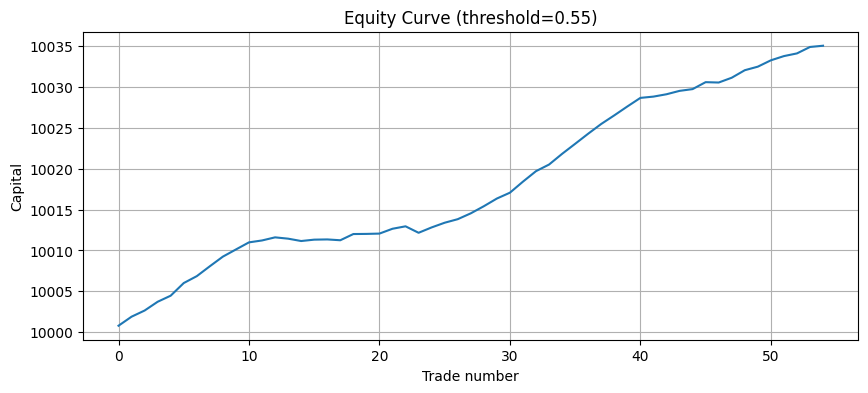

In [16]:
# ------------------------------ Full LSTM + PnL + Auto-Threshold Backtest ------------------------------
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import math

# ------------------- CONFIG -------------------
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
seq_len = 8
target_horizons = [3,6,12]
split_ratio = 0.8

# Backtest params
initial_capital = 10000.0
risk_per_trade = 0.01
slippage_pct = 0.0005
fee_pct = 0.001
cooldown_bars = 0
pos_threshold = 0.01
min_volatility = 0.0005
use_atr_normalization = True

# Loss params
alpha = 1.0
beta = 0.5
R_SCALE = 0.02

# Training
epochs = 40
batch_size = 64
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ------------------- Helpers -------------------
def compute_max_future_return_for_sequences(df, seq_len, target_horizons):
    prices = df['close'].values
    n = len(prices)
    max_h = max(target_horizons)
    max_ret = np.zeros(n, dtype=float)
    for t in range(n):
        best = 0.0
        for h in target_horizons:
            if t + h < n:
                fut_max = np.max(prices[t+1:t+1+h])
                r = (fut_max - prices[t]) / (prices[t] + 1e-9)
                if r > best: best = r
        max_ret[t] = best
    return max_ret[seq_len:]

def prepare_combined_y(y_binary, raw_max_ret, R_SCALE=0.02):
    r_norm = np.tanh(raw_max_ret / R_SCALE).astype(np.float32)
    y_comb = np.vstack([y_binary.astype(np.float32), r_norm]).T
    return y_comb

def expected_pnl_plus_bce_loss(alpha=1.0, beta=0.5):
    def loss_fn(y_true, y_pred):
        eps = K.epsilon()
        y_label = K.clip(y_true[:,0], 0.0, 1.0)
        r_norm = K.clip(y_true[:,1], -1.0, 1.0)
        p = K.clip(y_pred[:,0], eps, 1.0-eps)
        expected_pnl = K.mean(p * r_norm)
        bce = K.mean(K.binary_crossentropy(y_label, p))
        return -alpha * expected_pnl + beta * bce
    return loss_fn

def binary_accuracy_from_combined(y_true, y_pred):
    y_label = K.round(K.clip(y_true[:,0], 0.0, 1.0))
    p = K.round(K.clip(y_pred[:,0], 0.0, 1.0))
    return K.mean(K.cast(K.equal(y_label, p), dtype='float32'))

# ------------------- Build X, y per coin -------------------
dfs = []  # will hold all coin dfs concatenated
X_list, y_list, raw_ret_list = [], [], []
scaler = StandardScaler()
features = ['close','volume','rsi','atr','ma_diff','vol_change']

for coin, df in df_coins.items():
    # scale features
    df_features = df[features].values
    df_scaled = scaler.fit_transform(df_features)
    # build sequences
    prices = df['close'].values
    raw_max_ret_seq = compute_max_future_return_for_sequences(df, seq_len, target_horizons)
    for i in range(seq_len, len(df_scaled)):
        if i + max(target_horizons) >= len(df):  # ensure we have future for PnL
            continue
        X_list.append(df_scaled[i-seq_len:i])
        # binary label: >0.5% in 3 bars horizon
        future_return = (prices[i + target_horizons[0]] - prices[i]) / prices[i]
        y_list.append(1 if future_return > 0.005 else 0)
        raw_ret_list.append(raw_max_ret_seq[i-seq_len])

X = np.array(X_list)
y_binary = np.array(y_list)
raw_max_ret_seq = np.array(raw_ret_list)

# ------------------- Split Train/Val/Test -------------------
N = len(X)
split1 = int(split_ratio * N)
split2 = int((split_ratio + (1-split_ratio)/2)*N)  # simple 80/10/10 split

X_train, X_val, X_test = X[:split1], X[split1:split2], X[split2:]
y_train_bin, y_val_bin, y_test_bin = y_binary[:split1], y_binary[split1:split2], y_binary[split2:]
raw_max_ret_train, raw_max_ret_val, raw_max_ret_test = raw_max_ret_seq[:split1], raw_max_ret_seq[split1:split2], raw_max_ret_seq[split2:]

y_train_comb = prepare_combined_y(y_train_bin, raw_max_ret_train, R_SCALE)
y_val_comb   = prepare_combined_y(y_val_bin, raw_max_ret_val, R_SCALE)
y_test_comb  = prepare_combined_y(y_test_bin, raw_max_ret_test, R_SCALE)

# ------------------- Build LSTM -------------------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_len, X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=expected_pnl_plus_bce_loss(alpha=alpha, beta=beta),
    metrics=[binary_accuracy_from_combined]
)

# ------------------- Train -------------------
history = model.fit(
    X_train, y_train_comb,
    validation_data=(X_val, y_val_comb),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)

# ------------------- Prediction -------------------
probs_test = model.predict(X_test).flatten()
y_test_bin_comb = y_test_comb[:,0]

# ------------------- Threshold Scan + Backtest -------------------
thresholds = np.arange(0.01, 0.96, 0.01)
scan_results = []

for thr in thresholds:
    preds_thr = (probs_test >= thr).astype(int)
    acc = accuracy_score(y_test_bin_comb, preds_thr)
    prec = precision_score(y_test_bin_comb, preds_thr, zero_division=0)
    rec = recall_score(y_test_bin_comb, preds_thr, zero_division=0)
    f1 = f1_score(y_test_bin_comb, preds_thr, zero_division=0)
    auc = roc_auc_score(y_test_bin_comb, probs_test)
    cm = confusion_matrix(y_test_bin_comb, preds_thr)

    # Simple backtest per your earlier function (replace simulate_trades_for_threshold)
    bt = simulate_trades_for_threshold(thr, probs_test, meta_entry_prices, meta_future_matrix,
                                       pos_threshold=pos_threshold, slippage_pct=slippage_pct, fee_pct=fee_pct,
                                       initial_capital=initial_capital, risk_per_trade=risk_per_trade, cooldown_bars=cooldown_bars)
    scan_results.append({
        'threshold': thr,
        'acc': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc,
        'total_trades': bt['total_trades'],
        'total_pnl': bt['total_pnl'],
        'final_capital': bt['final_capital'],
        'win_rate': bt['win_rate'],
        'avg_pnl': bt['avg_pnl'],
        'sharpe': bt['sharpe'],
        'bt_obj': bt
    })

scan_df = pd.DataFrame(scan_results)
best_row = scan_df.loc[scan_df['total_pnl'].idxmax()]
best_thr = best_row['threshold']

print("✅ Best threshold:", best_thr)
print(best_row[['threshold','total_trades','total_pnl','final_capital','win_rate','sharpe','f1']])

# Confusion matrix at best threshold
best_preds = (probs_test >= best_thr).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test_bin_comb, best_preds))
print(classification_report(y_test_bin_comb, best_preds, digits=4))

# Plot equity curve
best_bt = best_row['bt_obj']
if not best_bt['trades'].empty:
    trades_df = best_bt['trades'].reset_index(drop=True)
    trades_df['cum_capital'] = trades_df['capital']
    plt.figure(figsize=(10,4))
    plt.plot(trades_df['cum_capital'])
    plt.title(f'Equity Curve (threshold={best_thr:.2f})')
    plt.xlabel('Trade number')
    plt.ylabel('Capital')
    plt.grid(True)
    plt.show()
